[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train RF-DETR Object Detection on a Custom Dataset

---

[![hf space](https://img.shields.io/badge/%F0%9F%A4%97%20Hugging%20Face-Spaces-blue)](https://huggingface.co/spaces/SkalskiP/RF-DETR)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-finetune-rf-detr-on-detection-dataset.ipynb)
[![roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/rf-detr)
[![code](https://badges.aleen42.com/src/github.svg)](https://github.com/roboflow/rf-detr)

RF-DETR is a real-time transformer architecture for object detection and instance segmentation developed by Roboflow. Built on a DINOv2 vision transformer backbone, RF-DETR delivers state-of-the-art accuracy and latency trade-offs on [Microsoft COCO](https://cocodataset.org/#home) and [RF100-VL](https://github.com/roboflow/rf100-vl).

RF-DETR uses a DINOv2 vision transformer backbone and supports both detection and instance segmentation in a single, consistent API. All core models and code are released under the Apache 2.0 license.

<img alt="rf_detr_1-4_latency_accuracy_object_detection" src="https://storage.googleapis.com/com-roboflow-marketing/rf-detr/rf_detr_1-4_latency_accuracy_object_detection.png" />

## Environment setup

### Configure API Key

To fine-tune RF-DETR, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy` to copy your private API key.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store your Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [ ]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Thu Jan 22 19:16:44 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   38C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install dependencies

Installs RF-DETR version 1.4.0 or higher, along with Supervision for benchmarking and Roboflow for pulling datasets and uploading models to the Roboflow platform.

In [12]:
!pip install rfdetr>=1.4.0 supervision roboflow inference tqdm matplotlib opencv-python

zsh:1: 1.4.0 not found


In [ ]:
!pip install torch==2.8.0+cu128  --index-url https://download.pytorch.org/whl/cu128

In [1]:
!pip3 install git+https://github.com/laudominik/torch-arcade

  Cloning https://github.com/laudominik/torch-arcade to /private/var/folders/gp/j593vlkj0jjbz68g1hsn82wh0000gn/T/pip-req-build-2a17l3fq
  Running command git clone --filter=blob:none --quiet https://github.com/laudominik/torch-arcade /private/var/folders/gp/j593vlkj0jjbz68g1hsn82wh0000gn/T/pip-req-build-2a17l3fq
  Resolved https://github.com/laudominik/torch-arcade to commit 2d8933b4e48ffc4afc02018ca9d506250f663be3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pycocotools-2.0.11-cp311-cp311-macosx_10_9_universal2.whl.metadata (1.3 kB)
  Using cached filelock-3.20.3-py3-none-any.whl.metadata (2.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.6.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2026.1.0-py3-none-any.whl.metadata (10 kB)
  Using cached pillow-12.1.0-cp311

### Download example data

Downloads example images for testing. You can use these or replace them with your own images.

In [ ]:
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg

## Inference with Pre-trained COCO Model

Runs inference on an example image using a pretrained RF-DETR Medium model (trained on COCO). To use a different model size, simply replace `RFDETRMedium` with `RFDETRNano`, `RFDETRSmall`, `RFDETRBase` or `RFDETRLarge` as needed.

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


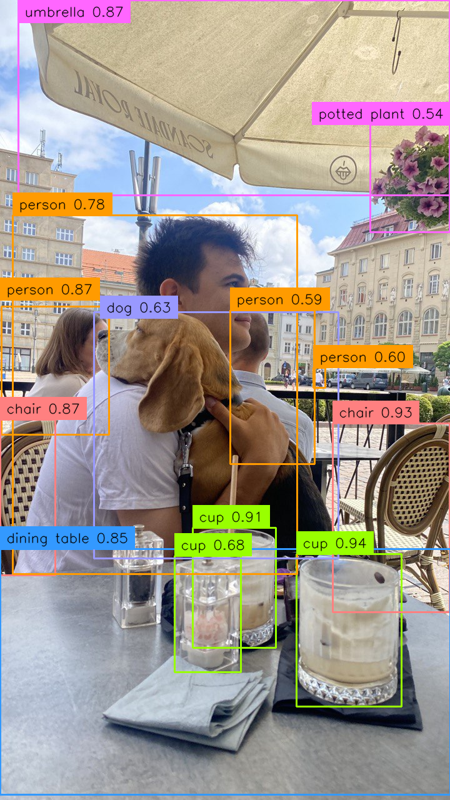

In [ ]:
import numpy as np
import supervision as sv

from PIL import Image

from rfdetr import RFDETRMedium
from rfdetr.util.coco_classes import COCO_CLASSES

image = Image.open("dog-2.jpeg")

model = RFDETRMedium(resolution=640)
model.optimize_for_inference()

detections = model.predict(image, threshold=0.5)

color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])
text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

bbox_annotator = sv.BoxAnnotator(color=color, thickness=thickness)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    smart_position=True
)

labels = [
    f"{COCO_CLASSES[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = bbox_annotator.annotate(annotated_image, detections)
annotated_image = label_annotator.annotate(annotated_image, detections, labels)
annotated_image.thumbnail((800, 800))
annotated_image

## Download Dataset from Roboflow Universe

RF-DETR expects the dataset to be in COCO format. Divide your dataset into three subdirectories: `train`, `valid`, and `test`. Each subdirectory should contain its own `_annotations.coco.json` file that holds the annotations for that particular split, along with the corresponding image files. Below is an example of the directory structure:

```
dataset/
├── train/
│   ├── _annotations.coco.json
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ... (other image files)
├── valid/
│   ├── _annotations.coco.json
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ... (other image files)
└── test/
    ├── _annotations.coco.json
    ├── image1.jpg
    ├── image2.jpg
    └── ... (other image files)
```

[Roboflow](https://roboflow.com/annotate) allows you to create object detection datasets from scratch or convert existing datasets from formats like YOLO, and then export them in COCO JSON format for training. You can also explore [Roboflow Universe](https://universe.roboflow.com/) to find pre-labeled datasets for a range of use cases.

In [ ]:
from roboflow import download_dataset

dataset = download_dataset("https://universe.roboflow.com/roboflow-jvuqo/basketball-player-detection-2/13", "coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to basketball-player-detection-2-13 in coco:: 100%|██████████| 1406/1406 [00:00<00:00, 4046.39it/s]


## Train RF-DETR on custom dataset

### Choose the right `batch_size`

Different GPUs have different amounts of VRAM (video memory), which limits how much data they can handle at once during training. To make training work well on any machine, you can adjust two settings: `batch_size` and `grad_accum_steps`. These control how many samples are processed at a time. The key is to keep their product equal to 16 — that’s our recommended total batch size. For example, on powerful GPUs like the A100, set `batch_size=16` and `grad_accum_steps=1`. On smaller GPUs like the T4, use `batch_size=4` and `grad_accum_steps=4`. We use a method called gradient accumulation, which lets the model simulate training with a larger batch size by gradually collecting updates before adjusting the weights.

In [ ]:
from rfdetr import RFDETRNano

model = RFDETRNano()

model.train(dataset_dir=dataset.location, epochs=10, batch_size=8, grad_accum_steps=2)

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights
Failed to load pretrain weights: PytorchStreamReader failed reading zip archive: failed finding central directory
Failed to load pretrain weights, re-downloading


rf-detr-nano.pth: 100%|██████████| 349M/349M [00:16<00:00, 22.1MiB/s]


TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir output' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=6, grad_accum_steps=2, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=8, weight_decay=0.0001, epochs=10, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-nano.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[3, 6, 9, 12], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=2, dim_feedforward=2048, hidden_dim=256, sa_nheads=8, ca_nheads=1

Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an erro

Epoch: [0]  [ 0/65]  eta: 0:02:21  lr: 0.000100  class_error: 93.83  loss: 7.6190 (7.6190)  loss_ce: 1.1873 (1.1873)  loss_bbox: 0.3462 (0.3462)  loss_giou: 0.9597 (0.9597)  loss_ce_0: 1.1472 (1.1472)  loss_bbox_0: 0.3870 (0.3870)  loss_giou_0: 0.9851 (0.9851)  loss_ce_enc: 1.2261 (1.2261)  loss_bbox_enc: 0.3759 (0.3759)  loss_giou_enc: 1.0045 (1.0045)  loss_ce_unscaled: 1.1873 (1.1873)  class_error_unscaled: 93.8344 (93.8344)  loss_bbox_unscaled: 0.0692 (0.0692)  loss_giou_unscaled: 0.4799 (0.4799)  cardinality_error_unscaled: 3882.2500 (3882.2500)  loss_ce_0_unscaled: 1.1472 (1.1472)  loss_bbox_0_unscaled: 0.0774 (0.0774)  loss_giou_0_unscaled: 0.4925 (0.4925)  cardinality_error_0_unscaled: 3883.6250 (3883.6250)  loss_ce_enc_unscaled: 1.2261 (1.2261)  loss_bbox_enc_unscaled: 0.0752 (0.0752)  loss_giou_enc_unscaled: 0.5023 (0.5023)  cardinality_error_enc_unscaled: 3883.6250 (3883.6250)  time: 2.1773  data: 0.6572  max mem: 3708
Epoch: [0]  [10/65]  eta: 0:00:52  lr: 0.000100  class_er

Mean of empty slice
Mean of empty slice
Mean of empty slice


Test:  [ 0/24]  eta: 0:00:12  class_error: 5.81  loss: 4.2541 (4.2541)  loss_ce: 0.6016 (0.6016)  loss_bbox: 0.1197 (0.1197)  loss_giou: 0.6705 (0.6705)  loss_ce_0: 0.6289 (0.6289)  loss_bbox_0: 0.1279 (0.1279)  loss_giou_0: 0.6642 (0.6642)  loss_ce_enc: 0.6172 (0.6172)  loss_bbox_enc: 0.1327 (0.1327)  loss_giou_enc: 0.6914 (0.6914)  loss_ce_unscaled: 0.6016 (0.6016)  class_error_unscaled: 5.8065 (5.8065)  loss_bbox_unscaled: 0.0239 (0.0239)  loss_giou_unscaled: 0.3353 (0.3353)  cardinality_error_unscaled: 243.2500 (243.2500)  loss_ce_0_unscaled: 0.6289 (0.6289)  loss_bbox_0_unscaled: 0.0256 (0.0256)  loss_giou_0_unscaled: 0.3321 (0.3321)  cardinality_error_0_unscaled: 239.3750 (239.3750)  loss_ce_enc_unscaled: 0.6172 (0.6172)  loss_bbox_enc_unscaled: 0.0265 (0.0265)  loss_giou_enc_unscaled: 0.3457 (0.3457)  cardinality_error_enc_unscaled: 247.8750 (247.8750)  time: 0.5350  data: 0.2424  max mem: 5119
Test:  [10/24]  eta: 0:00:04  class_error: 3.74  loss: 4.2631 (4.3037)  loss_ce: 0.60

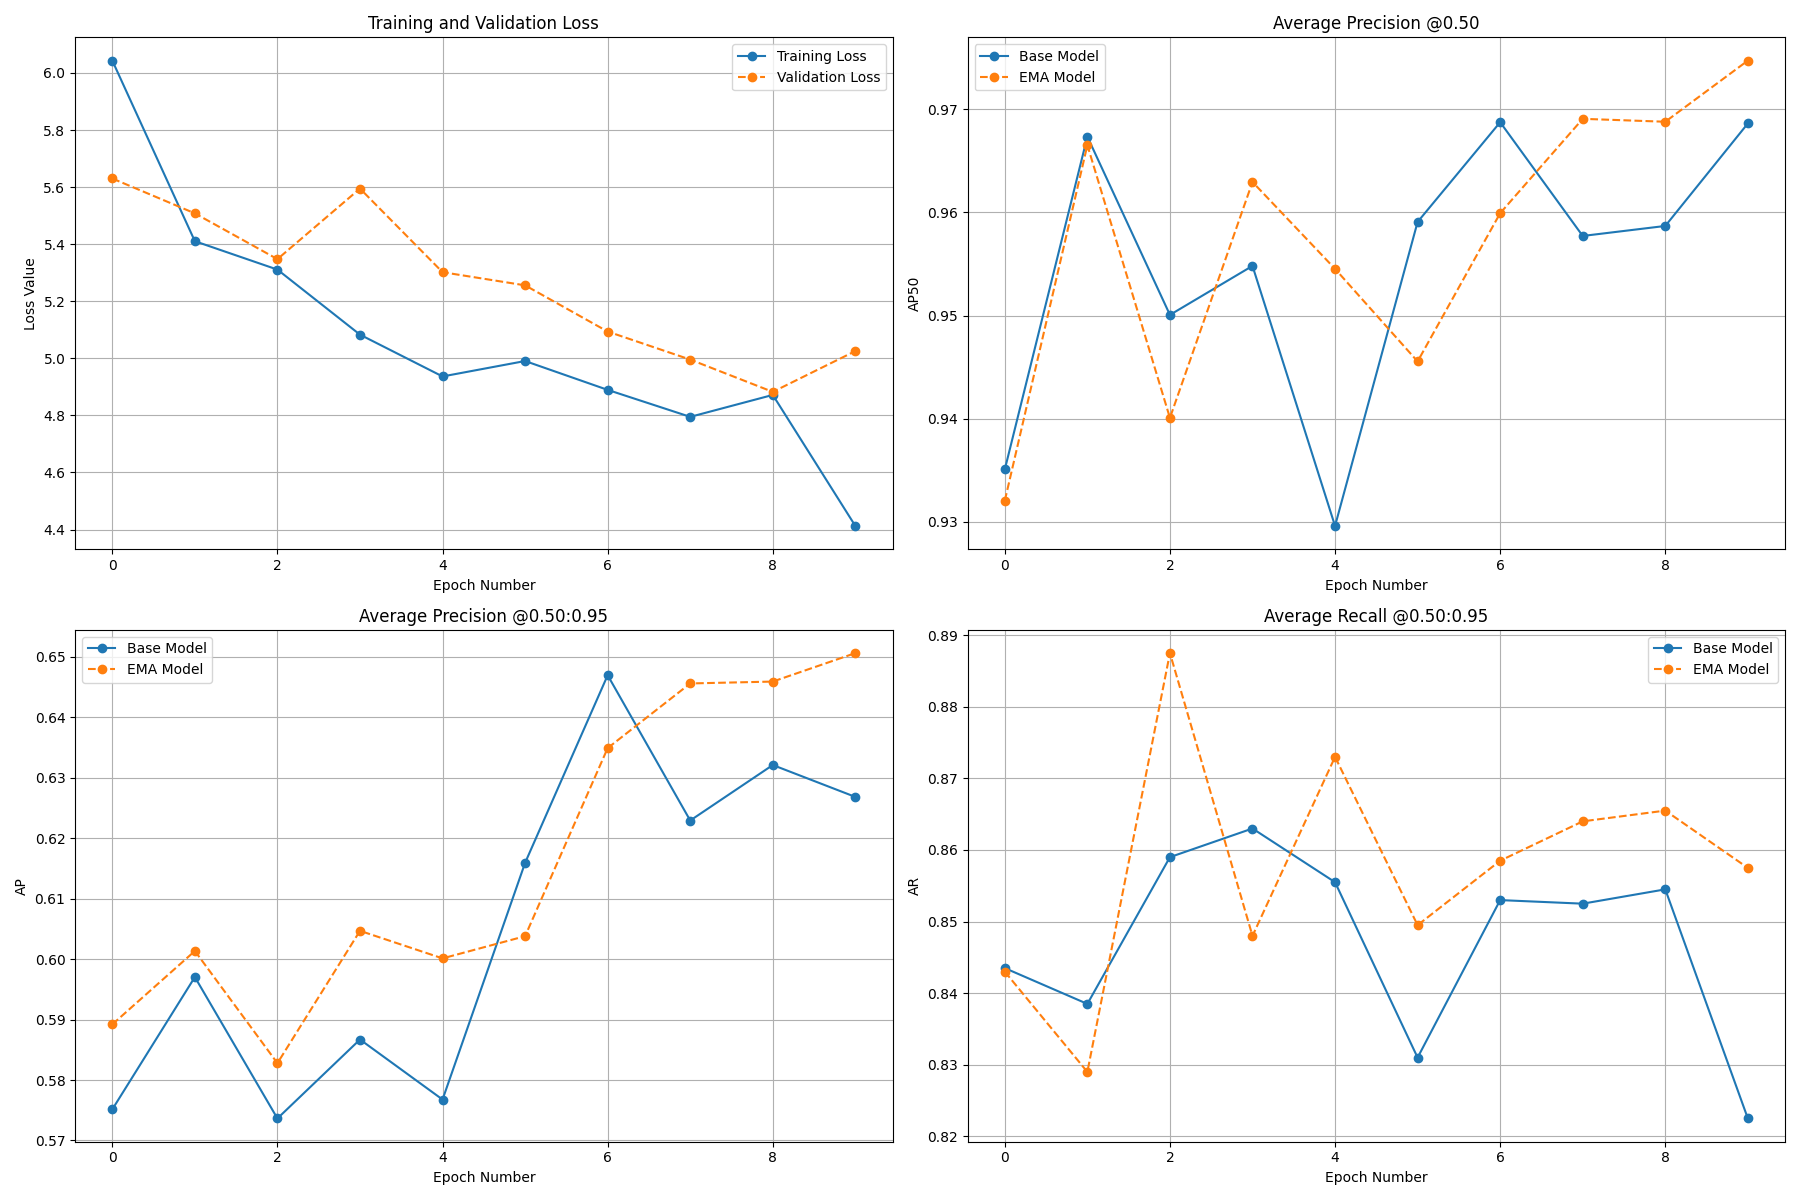

In [3]:
from PIL import Image

Image.open("/content/output/metrics_plot.png")

In [ ]:
!ls -la /content/output

total 1774316
drwxr-xr-x 3 root root      4096 Jan 22 19:33 .
drwxr-xr-x 1 root root      4096 Jan 22 19:21 ..
-rw-r--r-- 1 root root 484664813 Jan 22 19:33 checkpoint0009.pth
-rw-r--r-- 1 root root 362610474 Jan 22 19:33 checkpoint_best_ema.pth
-rw-r--r-- 1 root root 363841030 Jan 22 19:33 checkpoint_best_regular.pth
-rw-r--r-- 1 root root 120840095 Jan 22 19:33 checkpoint_best_total.pth
-rw-r--r-- 1 root root 484655501 Jan 22 19:33 checkpoint.pth
drwxr-xr-x 2 root root      4096 Jan 22 19:22 eval
-rw-r--r-- 1 root root      4412 Jan 22 19:33 events.out.tfevents.1769109679.cc039bb6718a.2442.0
-rw-r--r-- 1 root root     62193 Jan 22 19:33 log.txt
-rw-r--r-- 1 root root    173403 Jan 22 19:33 metrics_plot.png
-rw-r--r-- 1 root root      1874 Jan 22 19:33 results.json


## Convert Arcade dataset to coco

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import json
import shutil
from tqdm import tqdm
from dataclasses import dataclass, field

from typing import Callable, Optional, Union, Dict, List, Any, Tuple
from pathlib import Path
from torchvision.datasets.vision import VisionDataset
from torchvision.datasets.utils import download_and_extract_archive
from pycocotools.coco import COCO
from pycocotools import mask as mask_utils

try:
    import albumentations as A
except ImportError:
    A = None

try:
    import cv2
except ImportError:
    cv2 = None

    
def distinguish_side(segments):
    """Determine side based on vessel segments."""
    right_segments = {"1", "2", "3", "4", "16a", "16b", "16c"}
    return "right" if any(seg in segments for seg in right_segments) else "left"


@dataclass
class AugmentationParams:
    """
    Parameters for data augmentation during COCO dataset conversion.
    All probabilities default to 0 (disabled). Set > 0 to enable.
    """
    # Basic augmentations
    apply_augmentation: bool = False
    augmentation_factor: int = 1  # Number of augmented copies per original image
    
    # Flip augmentations
    horizontal_flip_p: float = 0.0
    vertical_flip_p: float = 0.0
    random_rotate_90_p: float = 0.0
    
    # Rotation
    rotate_p: float = 0.0
    rotate_limit: int = 15
    
    # Elastic/distortion augmentations
    elastic_transform_p: float = 0.0
    elastic_transform_alpha: float = 120.0
    elastic_transform_sigma: float = 6.0
    
    grid_distortion_p: float = 0.0
    optical_distortion_p: float = 0.0
    optical_distortion_limit: float = 0.05
    
    # Color/brightness augmentations
    random_brc_p: float = 0.0
    random_brc_b_limit: float = 0.2
    random_brc_c_limit: float = 0.2
    
    # Noise/blur
    gauss_noise_p: float = 0.0
    blur_p: float = 0.0
    blur_limit: int = 3
    
    # Spatial augmentations
    random_resized_crop_p: float = 0.0
    random_resized_crop_scale: Tuple[float, float] = (0.8, 1.0)
    random_resized_crop_ratio: Tuple[float, float] = (0.9, 1.1)
    
    shift_scale_rotate_p: float = 0.0
    shift_scale_rotate_shift_limit: float = 0.1
    shift_scale_rotate_scale_limit: float = 0.1


class ARCADEtoCocoConverter:
    """
    Converts ARCADE segmentation dataset to COCO detection format for RF-DETR.
    
    This converter reads the ARCADE dataset with segmentation masks and exports
    images and annotations in COCO format suitable for object detection training.
    Supports optional augmentations during conversion.
    
    Output structure:
        dataset/
        ├── train/
        │   ├── _annotations.coco.json
        │   └── *.png
        ├── valid/
        │   ├── _annotations.coco.json
        │   └── *.png
        └── test/
            ├── _annotations.coco.json
            └── *.png
    """
    
    URL: str = "https://zenodo.org/records/8386059/files/arcade_challenge_datasets.zip"
    ZIPNAME: str = "arcade_challenge_datasets.zip"
    FILENAME: str = "arcade_challenge_datasets"
    
    # Mapping from internal split names to output folder names
    OUTPUT_SPLIT_NAMES = {
        "train": "train",
        "val": "valid",
        "test": "test",
    }
    
    DATASET_DICT = {
        "segmentation": {
            "train": {
                "path": os.path.join("dataset_phase_1", "segmentation_dataset", "seg_train"),
                "coco": "seg_train.json",
            },
            "val": {
                "path": os.path.join("dataset_phase_1", "segmentation_dataset", "seg_val"),
                "coco": "seg_val.json"
            },
            "test": {
                "path": os.path.join("dataset_final_phase", "test_case_segmentation"),
                "coco": "instances_default.json"
            }
        },
        "stenosis": {
            "train": {
                "path": os.path.join("dataset_phase_1", "stenosis_dataset", "sten_train"),
                "coco": "sten_train.json"
            },
            "val": {
                "path": os.path.join("dataset_phase_1", "stenosis_dataset", "sten_val"),
                "coco": "sten_val.json"
            },
            "test": {
                "path": os.path.join("dataset_final_phase", "test_cases_stenosis"),
                "coco": "instances_default.json"
            }
        },
    }

    def __init__(
        self,
        root: Union[str, Path],
        output_dir: Union[str, Path],
        download: bool = False,
        task_type: str = "multiclass",
        min_area: float = 10.0,
        copy_images: bool = True,
        augmentation_params: Optional[AugmentationParams] = None,
        image_size: int = 512,
    ) -> None:
        """
        Initialize the ARCADE to COCO converter.
        
        Args:
            root: Root directory containing ARCADE dataset
            output_dir: Output directory for COCO format dataset
            download: Whether to download ARCADE dataset if not present
            task_type: "binary", "multiclass", or "stenosis"
            min_area: Minimum bounding box area to include annotation
            copy_images: If True, copies images; if False, creates symlinks
            augmentation_params: Optional augmentation parameters (only for train)
            image_size: Target image size for augmentations
        """
        self.root = Path(root)
        self.output_dir = Path(output_dir)
        self.task_type = task_type
        self.min_area = min_area
        self.copy_images = copy_images
        self.augmentation_params = augmentation_params
        self.image_size = image_size
        
        # Determine which ARCADE dataset folder to use
        if self.task_type == "stenosis":
            self._dataset_task = "stenosis"
        else:
            self._dataset_task = "segmentation"
        
        # Download if needed
        if download:
            download_and_extract_archive(self.URL, str(self.root), filename=self.ZIPNAME)
        
        # Category mapping will be built during conversion
        self.category_id_to_class_idx: Dict[int, int] = {}
        self.coco_categories: List[Dict[str, Any]] = []
        
        # Build augmentation pipeline if needed
        self.augs = None
        if augmentation_params and augmentation_params.apply_augmentation:
            if A is None:
                raise ImportError("Albumentations required for augmentations (pip install albumentations)")
            self.augs = self._build_augmentation_pipeline(augmentation_params)
    
    def _build_augmentation_pipeline(self, p: AugmentationParams) -> Any:
        """Build albumentations pipeline for bounding box augmentation."""
        aug_list: List[Any] = []
        
        if p.horizontal_flip_p > 0:
            aug_list.append(A.HorizontalFlip(p=p.horizontal_flip_p))
        if p.vertical_flip_p > 0:
            aug_list.append(A.VerticalFlip(p=p.vertical_flip_p))
        if p.random_rotate_90_p > 0:
            aug_list.append(A.RandomRotate90(p=p.random_rotate_90_p))
        
        if p.rotate_p > 0 and p.rotate_limit != 0:
            aug_list.append(A.Rotate(
                limit=p.rotate_limit, 
                p=p.rotate_p, 
                border_mode=0,
                interpolation=cv2.INTER_LINEAR if cv2 else 1,
            ))

        if p.elastic_transform_p > 0:
            aug_list.append(
                A.ElasticTransform(
                    alpha=p.elastic_transform_alpha,
                    sigma=p.elastic_transform_sigma,
                    p=p.elastic_transform_p,
                    border_mode=0,
                )
            )
        if p.grid_distortion_p > 0:
            aug_list.append(A.GridDistortion(
                p=p.grid_distortion_p, 
                border_mode=0,
            ))
        if p.optical_distortion_p > 0:
            aug_list.append(
                A.OpticalDistortion(
                    distort_limit=p.optical_distortion_limit,
                    shift_limit=0.05,
                    p=p.optical_distortion_p,
                )
            )
        if p.random_brc_p > 0:
            aug_list.append(
                A.RandomBrightnessContrast(
                    brightness_limit=p.random_brc_b_limit,
                    contrast_limit=p.random_brc_c_limit,
                    p=p.random_brc_p,
                )
            )
        if p.gauss_noise_p > 0:
            aug_list.append(A.GaussNoise(p=p.gauss_noise_p))
        if p.blur_p > 0:
            aug_list.append(A.Blur(blur_limit=int(p.blur_limit), p=p.blur_p))
        
        if p.random_resized_crop_p > 0:
            aug_list.append(
                A.RandomResizedCrop(
                    size=(self.image_size, self.image_size),
                    scale=p.random_resized_crop_scale,
                    ratio=p.random_resized_crop_ratio,
                    p=p.random_resized_crop_p
                )
            )
        
        if p.shift_scale_rotate_p > 0:
            aug_list.append(
                A.Affine(
                    translate_percent={
                        "x": (-p.shift_scale_rotate_shift_limit, p.shift_scale_rotate_shift_limit),
                        "y": (-p.shift_scale_rotate_shift_limit, p.shift_scale_rotate_shift_limit)
                    },
                    scale=(1 - p.shift_scale_rotate_scale_limit, 1 + p.shift_scale_rotate_scale_limit),
                    rotate=0,
                    p=p.shift_scale_rotate_p
                )
            )
        
        if not aug_list:
            return None
            
        return A.Compose(
            aug_list,
            bbox_params=A.BboxParams(
                format='coco',
                label_fields=['category_ids'],
                min_area=self.min_area,
                min_visibility=0.3,
            )
        )
        
    def _build_category_mapping(self, coco: COCO) -> None:
        """Build category mapping based on task type."""
        categories = coco.loadCats(coco.getCatIds())
        categories = sorted(categories, key=lambda cat: cat["id"])
        
        if self.task_type == "stenosis":
            stenosis_cat = next((cat for cat in categories if cat["name"] == "stenosis"), None)
            if stenosis_cat is None:
                raise ValueError("Stenosis category not found in dataset")
            
            self.category_id_to_class_idx = {stenosis_cat["id"]: 1}
            self.coco_categories = [{
                "id": 1,
                "name": "stenosis",
                "supercategory": "vessel"
            }]
            print(f"Stenosis mode: 1 category (stenosis)")
            
        elif self.task_type == "multiclass":
            EXCLUDED_CATEGORIES = {26}  # stenosis not used in vessel segmentation
            
            self.category_id_to_class_idx = {}
            self.coco_categories = []
            contiguous_idx = 1
            
            for category in categories:
                if category["id"] not in EXCLUDED_CATEGORIES:
                    self.category_id_to_class_idx[category["id"]] = contiguous_idx
                    self.coco_categories.append({
                        "id": contiguous_idx,
                        "name": category["name"],
                        "supercategory": category.get("supercategory", "vessel")
                    })
                    contiguous_idx += 1
            
            print(f"Multiclass mode: {len(self.coco_categories)} categories")
            
        else:  # binary
            self.category_id_to_class_idx = {}
            self.coco_categories = [{
                "id": 1,
                "name": "vessel",
                "supercategory": "vessel"
            }]
            for category in categories:
                if category["name"] != "stenosis":
                    self.category_id_to_class_idx[category["id"]] = 1
            print(f"Binary mode: 1 category (vessel)")
    
    def _mask_to_bbox(self, mask: np.ndarray) -> Optional[List[float]]:
        """Convert binary mask to bounding box [x, y, width, height]."""
        rows = np.any(mask, axis=1)
        cols = np.any(mask, axis=0)
        
        if not rows.any() or not cols.any():
            return None
            
        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]
        
        x, y = float(cmin), float(rmin)
        width = float(cmax - cmin + 1)
        height = float(rmax - rmin + 1)
        
        return [x, y, width, height]
    
    def _mask_to_polygon(self, mask: np.ndarray) -> List[List[float]]:
        """Convert binary mask to polygon segmentation format."""
        if cv2 is None:
            bbox = self._mask_to_bbox(mask)
            if bbox is None:
                return []
            x, y, w, h = bbox
            return [[x, y, x+w, y, x+w, y+h, x, y+h]]
        
        contours, _ = cv2.findContours(
            mask.astype(np.uint8), 
            cv2.RETR_EXTERNAL, 
            cv2.CHAIN_APPROX_SIMPLE
        )
        
        polygons = []
        for contour in contours:
            if contour.shape[0] >= 3:
                polygon = contour.flatten().tolist()
                if len(polygon) >= 6:
                    polygons.append(polygon)
        
        return polygons
    
    def _bbox_to_polygon(self, bbox: List[float]) -> List[List[float]]:
        """Convert bounding box [x, y, width, height] to polygon segmentation format.
        
        This creates a rectangular polygon from the bbox coordinates.
        Used as fallback when real segmentation is not available.
        """
        x, y, w, h = bbox
        # Create rectangular polygon: [x1,y1, x2,y1, x2,y2, x1,y2]
        polygon = [
            float(x), float(y),           # top-left
            float(x + w), float(y),       # top-right
            float(x + w), float(y + h),   # bottom-right
            float(x), float(y + h)        # bottom-left
        ]
        return [polygon]
    
    def _compute_area(self, mask: np.ndarray) -> float:
        """Compute mask area."""
        return float(np.sum(mask > 0))
    
    def _apply_augmentation(
        self,
        image: np.ndarray,
        bboxes: List[List[float]],
        category_ids: List[int],
    ) -> Tuple[np.ndarray, List[List[float]], List[int]]:
        """Apply augmentation to image and bounding boxes."""
        if self.augs is None:
            return image, bboxes, category_ids
        
        try:
            augmented = self.augs(
                image=image,
                bboxes=bboxes,
                category_ids=category_ids,
            )
            return augmented['image'], augmented['bboxes'], augmented['category_ids']
        except Exception as e:
            print(f"Warning: Augmentation failed: {e}")
            return image, bboxes, category_ids
    
    def convert_split(self, image_set: str) -> Dict[str, Any]:
        """
        Convert a single split (train/val/test) to COCO format.
        
        Args:
            image_set: One of "train", "val", "test"
            
        Returns:
            COCO format dictionary
        """
        task_dict = self.DATASET_DICT[self._dataset_task][image_set]
        dataset_dir = self.root / self.FILENAME / task_dict["path"]
        coco_file = dataset_dir / "annotations" / task_dict["coco"]
        image_dir = dataset_dir / "images"
        
        print(f"\n[{image_set.upper()}] Loading COCO annotations from {coco_file}")
        coco = COCO(str(coco_file))
        
        # Build category mapping on first split
        if not self.coco_categories:
            self._build_category_mapping(coco)
        
        # Map split name to output folder name (e.g., "val" -> "valid")
        output_split_name = self.OUTPUT_SPLIT_NAMES.get(image_set, image_set)
        
        # Create output directories
        output_image_dir = self.output_dir / output_split_name
        output_image_dir.mkdir(parents=True, exist_ok=True)
        
        # Initialize COCO output structure
        coco_output = {
            "images": [],
            "annotations": [],
            "categories": self.coco_categories
        }
        
        annotation_id = 1
        image_id_counter = 1
        images_processed = 0
        annotations_added = 0
        
        # Determine augmentation factor
        aug_factor = 1
        apply_augs = False
        if (self.augmentation_params 
            and self.augmentation_params.apply_augmentation 
            and self.augs is not None 
            and image_set == "train"):
            aug_factor = self.augmentation_params.augmentation_factor
            apply_augs = True
            print(f"  Augmentation enabled: {aug_factor}x factor")
        
        # Process each image
        image_list = coco.dataset['images']
        for img_info in tqdm(image_list, desc=f"Processing {image_set}"):
            img_filename = img_info['file_name']
            img_path = image_dir / img_filename
            
            if not img_path.exists() or not img_filename.endswith('.png'):
                continue
            
            orig_img_id = img_info['id']
            
            # Load image
            image = np.array(Image.open(img_path).convert('RGB'))
            
            # Get annotations for this image
            ann_ids = coco.getAnnIds(imgIds=orig_img_id)
            annotations = coco.loadAnns(ann_ids)
            
            # Collect bboxes and categories
            bboxes = []
            category_ids = []
            segmentations = []
            
            for ann in annotations:
                category_id = ann["category_id"]
                
                # Skip if category not in our mapping
                if category_id not in self.category_id_to_class_idx:
                    continue
                
                new_category_id = self.category_id_to_class_idx[category_id]
                
                # Get mask and compute bbox
                mask = coco.annToMask(ann)
                bbox = self._mask_to_bbox(mask)
                
                if bbox is None:
                    continue
                
                area = bbox[2] * bbox[3]
                if area < self.min_area:
                    continue
                
                bboxes.append(bbox)
                category_ids.append(new_category_id)
                segmentations.append(self._mask_to_polygon(mask))
            
            if not bboxes:
                continue
            
            # Process original + augmented versions
            for aug_idx in range(aug_factor):
                if aug_idx == 0:
                    # Original image - use real polygon segmentations
                    proc_image = image.copy()
                    proc_bboxes = bboxes.copy()
                    proc_cats = category_ids.copy()
                    proc_segs = segmentations.copy()  # Use real segmentations
                    suffix = ""
                else:
                    # Augmented version - generate bbox-derived segmentations
                    if not apply_augs:
                        continue
                    proc_image, proc_bboxes, proc_cats = self._apply_augmentation(
                        image.copy(), bboxes.copy(), category_ids.copy()
                    )
                    # For augmented images, derive segmentation from bbox
                    proc_segs = [self._bbox_to_polygon(bbox) for bbox in proc_bboxes]
                    suffix = f"_aug{aug_idx}"
                
                if not proc_bboxes:
                    continue
                
                # Save image
                base_name = img_filename.replace('.png', '')
                new_filename = f"{base_name}{suffix}.png"
                output_img_path = output_image_dir / new_filename
                
                Image.fromarray(proc_image).save(output_img_path)
                
                # Add image info
                h, w = proc_image.shape[:2]
                coco_output["images"].append({
                    "id": image_id_counter,
                    "file_name": new_filename,
                    "width": w,
                    "height": h
                })
                
                # Add annotations with segmentation polygons
                for bbox, cat_id, seg in zip(proc_bboxes, proc_cats, proc_segs):
                    # Ensure segmentation is valid (non-empty list of polygons)
                    valid_seg = seg if seg and len(seg) > 0 else self._bbox_to_polygon(bbox)
                    
                    coco_ann = {
                        "id": annotation_id,
                        "image_id": image_id_counter,
                        "category_id": cat_id,
                        "bbox": list(bbox),
                        "area": bbox[2] * bbox[3],
                        "iscrowd": 0,
                        "segmentation": valid_seg,
                    }
                    coco_output["annotations"].append(coco_ann)
                    annotation_id += 1
                    annotations_added += 1
                
                image_id_counter += 1
            
            images_processed += 1
        
        print(f"[{image_set.upper()}] Processed {images_processed} source images")
        print(f"[{image_set.upper()}] Output: {len(coco_output['images'])} images, {annotations_added} annotations")
        
        return coco_output
    
    def convert(self, image_sets: List[str] = ["train", "val"]) -> None:
        """
        Convert ARCADE dataset to COCO format.
        
        Args:
            image_sets: List of splits to convert (e.g., ["train", "val", "test"])
        """
        self.output_dir.mkdir(parents=True, exist_ok=True)
        
        print(f"Converting ARCADE to COCO format")
        print(f"  Task type: {self.task_type}")
        print(f"  Output dir: {self.output_dir}")
        print(f"  Splits: {image_sets}")
        
        for image_set in image_sets:
            coco_data = self.convert_split(image_set)
            
            # Map split name to output folder name (e.g., "val" -> "valid")
            output_split_name = self.OUTPUT_SPLIT_NAMES.get(image_set, image_set)
            
            # Save COCO JSON
            output_json = self.output_dir / output_split_name / "_annotations.coco.json"
            with open(output_json, 'w') as f:
                json.dump(coco_data, f, indent=2)
            
            print(f"  Saved: {output_json}")
        
        # Create dataset info file
        info = {
            "description": f"ARCADE dataset converted to COCO format ({self.task_type} mode)",
            "task_type": self.task_type,
            "source": "ARCADE Challenge Dataset",
            "categories": self.coco_categories,
            "splits": image_sets,
            "augmentation": self.augmentation_params.__dict__ if self.augmentation_params else None,
        }
        info_file = self.output_dir / "dataset_info.json"
        with open(info_file, 'w') as f:
            json.dump(info, f, indent=2)
        
        print(f"\nConversion complete!")
        print(f"  Dataset info: {info_file}")
        print(f"  Categories: {len(self.coco_categories)}")


# Convenience function for quick conversion
def convert_arcade_to_coco(
    arcade_root: str,
    output_dir: str,
    task_type: str = "multiclass",
    image_sets: List[str] = ["train", "val"],
    download: bool = False,
    min_area: float = 10.0,
    augmentation_params: Optional[AugmentationParams] = None,
) -> None:
    """
    Convert ARCADE dataset to COCO detection format.
    
    Output folders: train/, valid/, test/
    
    Args:
        arcade_root: Path to ARCADE dataset root
        output_dir: Output directory for COCO format dataset  
        task_type: "binary", "multiclass", or "stenosis"
        image_sets: Splits to convert ("train", "val", "test")
        download: Download dataset if not present
        min_area: Minimum bbox area to include
        augmentation_params: Optional augmentation parameters (only for train)
    """
    converter = ARCADEtoCocoConverter(
        root=arcade_root,
        output_dir=output_dir,
        download=download,
        task_type=task_type,
        min_area=min_area,
        augmentation_params=augmentation_params,
    )
    converter.convert(image_sets=image_sets)

## Convert ARCADE Dataset to COCO Format

Use the `ARCADEtoCocoConverter` class to convert ARCADE segmentation masks to COCO detection format suitable for RF-DETR training.

In [17]:
# Example: Convert ARCADE dataset to COCO format for RF-DETR

# Define paths
ARCADE_ROOT = "./dataset/arcade_challenge_datasets"  # Path to extracted ARCADE dataset
OUTPUT_DIR = "./arcade_coco_detection"  # Output directory for COCO format

# Option 1: Use convenience function
convert_arcade_to_coco(
    arcade_root="./dataset",  # Parent folder containing arcade_challenge_datasets
    output_dir=OUTPUT_DIR,
    task_type="multiclass",  # "binary", "multiclass", or "stenosis"
    image_sets=["train", "val", "test"],  # Include test set
    download=False,  # Set True to download ARCADE if not present
    min_area=0.0,  # Filter out tiny annotations
)

# Option 2: Use class directly for more control
# converter = ARCADEtoCocoConverter(
#     root="./dataset",
#     output_dir=OUTPUT_DIR,
#     task_type="multiclass",
#     min_area=10.0,
#     copy_images=True,  # False to use symlinks instead
# )
# converter.convert(image_sets=["train", "val", "test"])

Converting ARCADE to COCO format
  Task type: multiclass
  Output dir: arcade_coco_detection
  Splits: ['train', 'val', 'test']

[TRAIN] Loading COCO annotations from dataset/arcade_challenge_datasets/dataset_phase_1/segmentation_dataset/seg_train/annotations/seg_train.json
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
Multiclass mode: 25 categories


Processing train: 100%|██████████| 1000/1000 [00:22<00:00, 43.97it/s]


[TRAIN] Processed 1000 source images
[TRAIN] Output: 1000 images, 4977 annotations
  Saved: arcade_coco_detection/train/_annotations.coco.json

[VAL] Loading COCO annotations from dataset/arcade_challenge_datasets/dataset_phase_1/segmentation_dataset/seg_val/annotations/seg_val.json
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


Processing val: 100%|██████████| 200/200 [00:04<00:00, 45.41it/s]


[VAL] Processed 200 source images
[VAL] Output: 200 images, 1021 annotations
  Saved: arcade_coco_detection/valid/_annotations.coco.json

[TEST] Loading COCO annotations from dataset/arcade_challenge_datasets/dataset_final_phase/test_case_segmentation/annotations/instances_default.json
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


Processing test: 100%|██████████| 300/300 [00:06<00:00, 45.09it/s]

[TEST] Processed 300 source images
[TEST] Output: 300 images, 1672 annotations
  Saved: arcade_coco_detection/test/_annotations.coco.json

Conversion complete!
  Dataset info: arcade_coco_detection/dataset_info.json
  Categories: 25


## Dataset Statistics

Analyze category distribution and annotation statistics in the converted COCO dataset.

In [8]:
!pip install matplotlib

  Using cached matplotlib-3.10.8-cp311-cp311-macosx_11_0_arm64.whl.metadata (52 kB)
  Using cached contourpy-1.3.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp311-cp311-macosx_10_9_universal2.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.3 kB)
Using cached matplotlib-3.10.8-cp311-cp311-macosx_11_0_arm64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp311-cp311-macosx_11_0_arm64.whl (270 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.61.1-cp311-cp311-macosx_10_9_universal2.whl (2.9 MB)
Using cached kiwisolver-1.4.9-cp311-cp311-macosx_11_0_arm64.whl (65 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.8/122.8 kB 1.2 MB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 24.0 -> 26.0
[notice] To update, run: pip install --upgrade pip



📊 TRAIN SPLIT STATISTICS
  📁 Images: 1000
  🏷️  Annotations: 4977
  📂 Categories: 25
  📈 Avg annotations/image: 4.98

  Category Distribution:
  --------------------------------------------------
  6                    |   536 ( 10.8%) | area: 451-4229 (μ=1457) | bbox: 96x51
  5                    |   527 ( 10.6%) | area: 227-2829 (μ=1086) | bbox: 58x34
  2                    |   375 (  7.5%) | area: 305-4986 (μ=1716) | bbox: 57x121
  1                    |   374 (  7.5%) | area: 375-3755 (μ=1693) | bbox: 96x69
  3                    |   369 (  7.4%) | area: 182-4659 (μ=1710) | bbox: 130x55
  7                    |   340 (  6.8%) | area: 466-4035 (μ=1876) | bbox: 84x150
  11                   |   320 (  6.4%) | area: 339-4574 (μ=1511) | bbox: 75x80
  8                    |   310 (  6.2%) | area: 442-3971 (μ=1658) | bbox: 78x182
  13                   |   306 (  6.1%) | area: 174-5091 (μ=1822) | bbox: 64x155
  4                    |   303 (  6.1%) | area: 281-5394 (μ=1465) | bbox: 176x

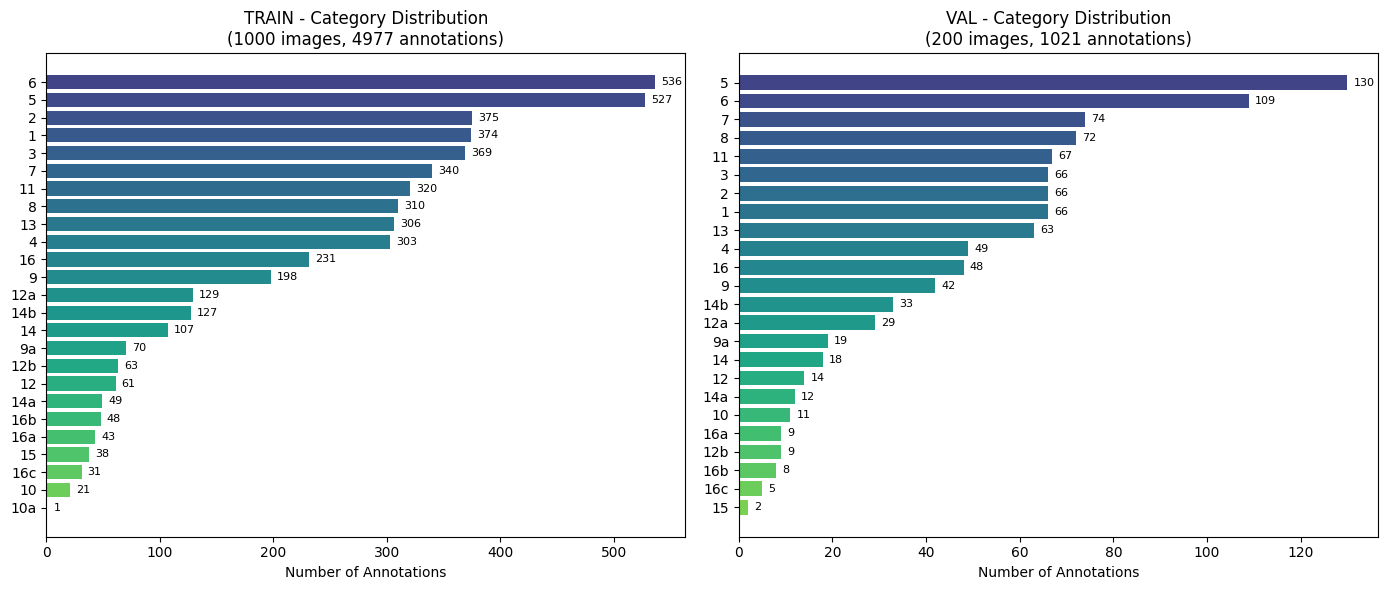

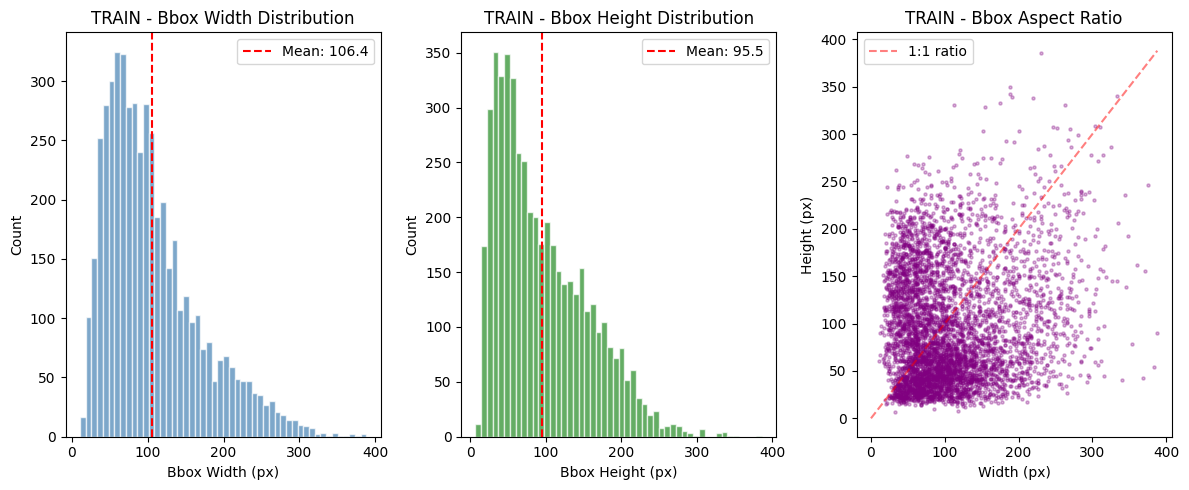


📐 Bounding Box Statistics (TRAIN):
  Width:  min=11, max=388, mean=106.4, std=62.6
  Height: min=7, max=386, mean=95.5, std=60.3


In [9]:
import json
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

def analyze_coco_dataset(dataset_dir: str, splits: list = ["train", "val"]):
    """
    Analyze COCO dataset and display category statistics.
    
    Args:
        dataset_dir: Path to COCO format dataset
        splits: List of splits to analyze
    """
    all_stats = {}
    
    for split in splits:
        ann_file = os.path.join(dataset_dir, split, "_annotations.coco.json")
        if not os.path.exists(ann_file):
            print(f"⚠️ {split}: annotation file not found at {ann_file}")
            continue
            
        with open(ann_file, 'r') as f:
            coco_data = json.load(f)
        
        # Build category id to name mapping
        cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
        
        # Count annotations per category
        category_counts = defaultdict(int)
        category_areas = defaultdict(list)
        category_bbox_sizes = defaultdict(list)
        
        for ann in coco_data['annotations']:
            cat_id = ann['category_id']
            cat_name = cat_id_to_name.get(cat_id, f"unknown_{cat_id}")
            category_counts[cat_name] += 1
            
            # Track areas
            if 'area' in ann:
                category_areas[cat_name].append(ann['area'])
            
            # Track bbox sizes
            if 'bbox' in ann:
                w, h = ann['bbox'][2], ann['bbox'][3]
                category_bbox_sizes[cat_name].append((w, h))
        
        # Calculate statistics
        stats = {
            'num_images': len(coco_data['images']),
            'num_annotations': len(coco_data['annotations']),
            'num_categories': len(coco_data['categories']),
            'categories': coco_data['categories'],
            'category_counts': dict(category_counts),
            'category_areas': {k: np.array(v) for k, v in category_areas.items()},
            'category_bbox_sizes': {k: np.array(v) for k, v in category_bbox_sizes.items()},
        }
        all_stats[split] = stats
        
        # Print summary
        print(f"\n{'='*60}")
        print(f"📊 {split.upper()} SPLIT STATISTICS")
        print(f"{'='*60}")
        print(f"  📁 Images: {stats['num_images']}")
        print(f"  🏷️  Annotations: {stats['num_annotations']}")
        print(f"  📂 Categories: {stats['num_categories']}")
        print(f"  📈 Avg annotations/image: {stats['num_annotations']/max(stats['num_images'],1):.2f}")
        
        print(f"\n  Category Distribution:")
        print(f"  {'-'*50}")
        
        # Sort by count descending
        sorted_cats = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)
        
        for cat_name, count in sorted_cats:
            pct = 100 * count / stats['num_annotations'] if stats['num_annotations'] > 0 else 0
            areas = category_areas[cat_name]
            bbox_sizes = category_bbox_sizes[cat_name]
            
            # Area stats
            area_min = np.min(areas) if len(areas) > 0 else 0
            area_max = np.max(areas) if len(areas) > 0 else 0
            area_mean = np.mean(areas) if len(areas) > 0 else 0
            
            # Bbox size stats
            if len(bbox_sizes) > 0:
                w_mean = np.mean([s[0] for s in bbox_sizes])
                h_mean = np.mean([s[1] for s in bbox_sizes])
                bbox_str = f"bbox: {w_mean:.0f}x{h_mean:.0f}"
            else:
                bbox_str = ""
            
            print(f"  {cat_name:20s} | {count:5d} ({pct:5.1f}%) | area: {area_min:.0f}-{area_max:.0f} (μ={area_mean:.0f}) | {bbox_str}")
    
    return all_stats


def plot_category_distribution(stats: dict, figsize=(14, 6)):
    """Plot category distribution across splits."""
    
    fig, axes = plt.subplots(1, len(stats), figsize=figsize)
    if len(stats) == 1:
        axes = [axes]
    
    for ax, (split, split_stats) in zip(axes, stats.items()):
        counts = split_stats['category_counts']
        sorted_cats = sorted(counts.items(), key=lambda x: x[1], reverse=True)
        
        # Take top 25 categories for readability
        if len(sorted_cats) > 25:
            sorted_cats = sorted_cats[:25]
        
        names = [c[0] for c in sorted_cats]
        values = [c[1] for c in sorted_cats]
        
        colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(names)))
        
        bars = ax.barh(names, values, color=colors)
        ax.set_xlabel('Number of Annotations')
        ax.set_title(f'{split.upper()} - Category Distribution\n({split_stats["num_images"]} images, {split_stats["num_annotations"]} annotations)')
        ax.invert_yaxis()
        
        # Add value labels
        for bar, val in zip(bars, values):
            ax.text(val + max(values)*0.01, bar.get_y() + bar.get_height()/2, 
                   f'{val}', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()


def plot_bbox_size_distribution(stats: dict, split: str = "train", figsize=(12, 5)):
    """Plot bounding box size distribution."""
    
    if split not in stats:
        print(f"Split '{split}' not found in stats")
        return
    
    split_stats = stats[split]
    bbox_sizes = split_stats['category_bbox_sizes']
    
    # Aggregate all bbox sizes
    all_widths = []
    all_heights = []
    for sizes in bbox_sizes.values():
        if len(sizes) > 0:
            all_widths.extend(sizes[:, 0])
            all_heights.extend(sizes[:, 1])
    
    if not all_widths:
        print("No bbox data available")
        return
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Width distribution
    axes[0].hist(all_widths, bins=50, color='steelblue', edgecolor='white', alpha=0.7)
    axes[0].axvline(np.mean(all_widths), color='red', linestyle='--', label=f'Mean: {np.mean(all_widths):.1f}')
    axes[0].set_xlabel('Bbox Width (px)')
    axes[0].set_ylabel('Count')
    axes[0].set_title(f'{split.upper()} - Bbox Width Distribution')
    axes[0].legend()
    
    # Height distribution
    axes[1].hist(all_heights, bins=50, color='forestgreen', edgecolor='white', alpha=0.7)
    axes[1].axvline(np.mean(all_heights), color='red', linestyle='--', label=f'Mean: {np.mean(all_heights):.1f}')
    axes[1].set_xlabel('Bbox Height (px)')
    axes[1].set_ylabel('Count')
    axes[1].set_title(f'{split.upper()} - Bbox Height Distribution')
    axes[1].legend()
    
    # Width vs Height scatter
    sample_size = min(5000, len(all_widths))
    indices = np.random.choice(len(all_widths), sample_size, replace=False)
    axes[2].scatter(
        [all_widths[i] for i in indices], 
        [all_heights[i] for i in indices], 
        alpha=0.3, s=5, c='purple'
    )
    axes[2].plot([0, max(all_widths)], [0, max(all_widths)], 'r--', alpha=0.5, label='1:1 ratio')
    axes[2].set_xlabel('Width (px)')
    axes[2].set_ylabel('Height (px)')
    axes[2].set_title(f'{split.upper()} - Bbox Aspect Ratio')
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary stats
    print(f"\n📐 Bounding Box Statistics ({split.upper()}):")
    print(f"  Width:  min={np.min(all_widths):.0f}, max={np.max(all_widths):.0f}, mean={np.mean(all_widths):.1f}, std={np.std(all_widths):.1f}")
    print(f"  Height: min={np.min(all_heights):.0f}, max={np.max(all_heights):.0f}, mean={np.mean(all_heights):.1f}, std={np.std(all_heights):.1f}")


# Analyze the converted dataset
# Note: Output folders are train/, valid/, test/
stats = analyze_coco_dataset(OUTPUT_DIR, splits=["train", "valid", "test"])

# Plot distributions
if stats:
    plot_category_distribution(stats)
    plot_bbox_size_distribution(stats, split="train")

## Deploy a Trained RF-DETR Model

Deploying to Roboflow allows you to create multi-step computer vision applications that run both in the cloud and your own hardware. Please wait a moment while Roboflow indexes your model.

In [ ]:
model.deploy_to_roboflow(
  workspace="roboflow-jvuqo",
  project_id="basketball-player-detection-2",
  version=13,
  api_key=os.environ["ROBOFLOW_API_KEY"]
)

loading Roboflow workspace...
loading Roboflow project...
View the status of your deployment at: https://app.roboflow.com/roboflow-jvuqo/basketball-player-detection-2/13
Share your model with the world at: https://universe.roboflow.com/roboflow-jvuqo/basketball-player-detection-2/model/13


## Evaluate Fine-tuned RF-DETR Model

Before benchmarking the model, we need to load the best saved checkpoint. To ensure it fits on the GPU, we first need to free up GPU memory. This involves deleting any remaining references to previously used objects, triggering Python’s garbage collector, and clearing the CUDA memory cache.

In [5]:
import gc
import torch
import weakref

def cleanup_gpu_memory(obj=None, verbose: bool = False):

    if not torch.cuda.is_available():
        if verbose:
            print("[INFO] CUDA is not available. No GPU cleanup needed.")
        return

    def get_memory_stats():
        allocated = torch.cuda.memory_allocated()
        reserved = torch.cuda.memory_reserved()
        return allocated, reserved

    torch.cuda.synchronize()

    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[Before] Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")

    # Ensure we drop all strong references
    if obj is not None:
        ref = weakref.ref(obj)
        del obj
        if ref() is not None and verbose:
            print("[WARNING] Object not fully garbage collected yet.")

    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

    torch.cuda.synchronize()

    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[After]  Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")

In [6]:
cleanup_gpu_memory(model, verbose=True)

[Before] Allocated: 372.22 MB | Reserved: 4498.00 MB
[WARNING] Object not fully garbage collected yet.
[After]  Allocated: 255.17 MB | Reserved: 364.00 MB


We load the best-performing model from the `checkpoint_best_total.pth` file using the `RFDETRMedium` class. This checkpoint contains the trained weights from our most successful training run. After loading, we call `optimize_for_inference()`, which prepares the model for efficient inference.

In [10]:
model = RFDETRNano(pretrain_weights="/content/output/checkpoint_best_total.pth")
# model.optimize_for_inference()

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


In [ ]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"./arcade_coco_dataset_seg/test",
    annotations_path=f"./arcade_coco_dataset_seg/test/_annotations.coco.json",
)

In [11]:
# 🔍 DIAGNOSTYKA: Sprawdź czy plik COCO zawiera maski segmentacji
import json

coco_path = "./arcade_coco_detection/val/_annotations.coco.json"

with open(coco_path, 'r') as f:
    coco_data = json.load(f)

print("=" * 60)
print("🔍 COCO FILE ANALYSIS")
print("=" * 60)

# Sprawdź strukturę
print(f"\n📁 Keys in COCO file: {list(coco_data.keys())}")
print(f"📊 Number of images: {len(coco_data.get('images', []))}")
print(f"📊 Number of annotations: {len(coco_data.get('annotations', []))}")
print(f"📊 Number of categories: {len(coco_data.get('categories', []))}")

# Sprawdź czy annotations mają pole "segmentation"
if coco_data.get('annotations'):
    first_ann = coco_data['annotations'][0]
    print(f"\n🔑 Keys in first annotation: {list(first_ann.keys())}")
    
    has_segmentation = 'segmentation' in first_ann
    print(f"\n✅ Has 'segmentation' field: {has_segmentation}")
    
    if has_segmentation:
        seg = first_ann['segmentation']
        print(f"   Segmentation type: {type(seg)}")
        if isinstance(seg, list) and len(seg) > 0:
            print(f"   Segmentation format: polygon (list of points)")
            print(f"   First polygon length: {len(seg[0]) if seg else 0} points")
        elif isinstance(seg, dict):
            print(f"   Segmentation format: RLE (counts + size)")
            print(f"   RLE keys: {list(seg.keys())}")
        else:
            print(f"   Segmentation is empty or unknown format")
    else:
        print("   ⚠️ Brak pola 'segmentation' - maski nie będą dostępne!")
        print("   💡 Musisz wygenerować plik COCO z maskami (polygon lub RLE)")

print("\n" + "=" * 60)

🔍 COCO FILE ANALYSIS

📁 Keys in COCO file: ['images', 'annotations', 'categories']
📊 Number of images: 200
📊 Number of annotations: 1021
📊 Number of categories: 25

🔑 Keys in first annotation: ['id', 'image_id', 'category_id', 'bbox', 'area', 'iscrowd', 'segmentation']

✅ Has 'segmentation' field: True
   Segmentation type: <class 'list'>
   Segmentation format: polygon (list of points)
   First polygon length: 680 points



In [15]:
# 🔍 DIAGNOSTYKA KLAS W ZBIORZE DANYCH
import json
from collections import Counter

print("=" * 80)
print("🔍 ANALIZA KLAS W ZBIORZE DANYCH")
print("=" * 80)

# Sprawdź plik COCO dla zbioru testowego
coco_path = "./arcade_coco_dataset_multiclass_seg/test/_annotations.coco.json"

with open(coco_path, 'r') as f:
    coco_data = json.load(f)

# 1. Kategorie zdefiniowane w pliku
print("\n📋 KATEGORIE ZDEFINIOWANE W PLIKU COCO:")
for cat in sorted(coco_data['categories'], key=lambda x: x['id']):
    print(f"   category_id={cat['id']:2d} -> '{cat['name']}'")

# 2. Jakie category_id są RZECZYWIŚCIE używane w annotations
category_ids_used = [ann['category_id'] for ann in coco_data['annotations']]
category_counts = Counter(category_ids_used)

print(f"\n📊 KATEGORIE RZECZYWIŚCIE UŻYWANE W ANNOTATIONS ({len(coco_data['annotations'])} total):")
for cat_id, count in sorted(category_counts.items()):
    cat_name = next((c['name'] for c in coco_data['categories'] if c['id'] == cat_id), 'UNKNOWN')
    print(f"   category_id={cat_id:2d} ({cat_name:20s}): {count:5d} instances")

# 3. Sprawdź zakres category_id
min_cat = min(category_ids_used) if category_ids_used else 0
max_cat = max(category_ids_used) if category_ids_used else 0
print(f"\n📈 Zakres category_id: {min_cat} - {max_cat}")

# 4. Sprawdź czy stenosis (26) jest w zbiorze
if 26 in category_counts:
    print(f"\n⚠️  STENOSIS (category_id=26) JEST W ZBIORZE: {category_counts[26]} instances")
else:
    print(f"\n✅ STENOSIS (category_id=26) NIE MA W ZBIORZE")

# 5. Sprawdź również zbiór treningowy
print("\n" + "=" * 80)
print("🔍 PORÓWNANIE: ZBIÓR TRENINGOWY vs TESTOWY")
print("=" * 80)

for split in ['train', 'test']:
    path = f"./arcade_coco_dataset_seg/{split}/_annotations.coco.json"
    try:
        with open(path, 'r') as f:
            data = json.load(f)
        cats_used = set(ann['category_id'] for ann in data['annotations'])
        print(f"\n{split.upper():5s}: {len(data['annotations']):5d} annotations, categories used: {sorted(cats_used)}")
        
        # Sprawdź czy wszystkie category_id są w zakresie 1-26
        out_of_range = [c for c in cats_used if c < 1 or c > 26]
        if out_of_range:
            print(f"   ⚠️  Out of range category_ids: {out_of_range}")
    except FileNotFoundError:
        print(f"\n{split.upper():5s}: File not found")

print("\n" + "=" * 80)

🔍 ANALIZA KLAS W ZBIORZE DANYCH

📋 KATEGORIE ZDEFINIOWANE W PLIKU COCO:
   category_id= 1 -> 'RCA_prox'
   category_id= 2 -> 'RCA_mid'
   category_id= 3 -> 'RCA_dist'
   category_id= 4 -> 'PDA'
   category_id= 5 -> 'LM'
   category_id= 6 -> 'LAD_prox'
   category_id= 7 -> 'LAD_mid'
   category_id= 8 -> 'LAD_apical'
   category_id= 9 -> 'D1'
   category_id=10 -> 'D1_branch_9a'
   category_id=11 -> 'D2'
   category_id=12 -> 'D2_branch_10a'
   category_id=13 -> 'LCx_prox_11'
   category_id=14 -> 'OM1_12'
   category_id=15 -> 'OM1_branch_12a'
   category_id=16 -> 'LCx_mid_13'
   category_id=17 -> 'OM2_14'
   category_id=18 -> 'OM2_branch_14a'
   category_id=19 -> 'LCx_dist_15'
   category_id=20 -> 'PLB_16'
   category_id=21 -> 'PLB_branch_16a'
   category_id=22 -> 'PLB_branch_16b'
   category_id=23 -> 'PLB_branch_16c'
   category_id=24 -> 'OM1_branch_12b'
   category_id=25 -> 'OM2_branch_14b'
   category_id=26 -> 'stenosis'

📊 KATEGORIE RZECZYWIŚCIE UŻYWANE W ANNOTATIONS (1669 total):
   c

In [16]:
# 🔍 DIAGNOSTYKA: Sprawdź ENCODING z torch_arcade
# Maski są w formacie ONE-HOT (H, W, 28 kanałów)!

from torch_arcade import ENCODING

print("🔍 ENCODING dictionary z torch_arcade:")
print("="*60)

# Posortuj po pierwszym indeksie 1 w wektorze
encoding_sorted = sorted(ENCODING.items(), key=lambda x: x[1].index(1) if 1 in x[1] else -1)

for name, one_hot in encoding_sorted:
    if 1 in one_hot:
        channel_idx = one_hot.index(1)
        print(f"   Kanał {channel_idx:2d}: {name}")
    else:
        print(f"   ❌ Brak 1: {name} -> {one_hot}")

print("\n" + "="*60)
print("📊 Mapowanie kanał -> klasa COCO (1-indexed):")
print("="*60)

# Stwórz mapowanie: kanał_idx -> (coco_class_id, nazwa)
CHANNEL_TO_COCO = {}
for name, one_hot in ENCODING.items():
    if 1 in one_hot:
        channel_idx = one_hot.index(1)
        CHANNEL_TO_COCO[channel_idx] = name

for ch in sorted(CHANNEL_TO_COCO.keys()):
    print(f"   Kanał {ch:2d} -> {CHANNEL_TO_COCO[ch]}")

🔍 ENCODING dictionary z torch_arcade:
   Kanał  0: background
   Kanał  1: 1
   Kanał  2: 2
   Kanał  3: 3
   Kanał  4: 4
   Kanał  5: 5
   Kanał  6: 6
   Kanał  7: 7
   Kanał  8: 8
   Kanał  9: 9
   Kanał 10: 9a
   Kanał 11: 10
   Kanał 12: 10a
   Kanał 13: 11
   Kanał 14: 12
   Kanał 15: 12a
   Kanał 16: 13
   Kanał 17: 14
   Kanał 18: 14a
   Kanał 19: 15
   Kanał 20: 16
   Kanał 21: 16a
   Kanał 22: 16b
   Kanał 23: 16c
   Kanał 24: 12b
   Kanał 25: 14b
   Kanał 26: stenosis

📊 Mapowanie kanał -> klasa COCO (1-indexed):
   Kanał  0 -> background
   Kanał  1 -> 1
   Kanał  2 -> 2
   Kanał  3 -> 3
   Kanał  4 -> 4
   Kanał  5 -> 5
   Kanał  6 -> 6
   Kanał  7 -> 7
   Kanał  8 -> 8
   Kanał  9 -> 9
   Kanał 10 -> 9a
   Kanał 11 -> 10
   Kanał 12 -> 10a
   Kanał 13 -> 11
   Kanał 14 -> 12
   Kanał 15 -> 12a
   Kanał 16 -> 13
   Kanał 17 -> 14
   Kanał 18 -> 14a
   Kanał 19 -> 15
   Kanał 20 -> 16
   Kanał 21 -> 16a
   Kanał 22 -> 16b
   Kanał 23 -> 16c
   Kanał 24 -> 12b
   Kanał 25 -> 

In [1]:
# 🔄 KONWERSJA ARCADE DATASET PHASE 1 -> COCO FORMAT (BEZ STENOSIS)
# Ładuje bezpośrednio z plików .npz bez użycia torch_arcade

import json
import numpy as np
from PIL import Image
import os
import cv2
from pycocotools import mask as mask_utils
from collections import Counter
from tqdm import tqdm

# ✅ ŚCIEŻKI DO DATASETU ARCADE PHASE 1
ARCADE_ROOT = "./dataset/arcade_challenge_datasets/dataset_phase_1/segmentation_dataset"

# ✅ KATALOG WYJŚCIOWY
OUTPUT_ROOT = "arcade_coco_dataset_multiclass_seg_NO_STENOSIS"

# ✅ MAPOWANIE KANAŁÓW ONE-HOT NA KLASY COCO
# Maski z ARCADESemanticSegmentation używają one-hot encoding (27 kanałów)
# Kanał 0 = background, Kanały 1-25 = tętnice, Kanał 26 = stenosis

# Mapowanie: kanał_idx (z argmax) -> COCO category_id
# Kanał jest taki sam jak category_id dla tętnic (1-25)
CHANNEL_TO_COCO_ID = {
    # kanał 0 = background (pomijamy)
    1: 1,   # RCA_prox
    2: 2,   # RCA_mid
    3: 3,   # RCA_dist
    4: 4,   # PDA
    5: 5,   # LM
    6: 6,   # LAD_prox
    7: 7,   # LAD_mid
    8: 8,   # LAD_apical
    9: 9,   # D1
    10: 10, # D1_branch_9a
    11: 11, # D2
    12: 12, # D2_branch_10a
    13: 13, # LCx_prox_11
    14: 14, # OM1_12
    15: 15, # OM1_branch_12a
    16: 16, # LCx_mid_13
    17: 17, # OM2_14
    18: 18, # OM2_branch_14a
    19: 19, # LCx_dist_15
    20: 20, # PLB_16
    21: 21, # PLB_branch_16a
    22: 22, # PLB_branch_16b
    23: 23, # PLB_branch_16c
    24: 24, # OM1_branch_12b
    25: 25, # OM2_branch_14b
    # kanał 26 = stenosis (pomijamy)
}

# 25 KLAS TĘTNIC WIEŃCOWYCH (BEZ STENOSIS!)
CLASS_ID_TO_LABEL = {
    1: "RCA_prox",
    2: "RCA_mid",
    3: "RCA_dist",
    4: "PDA",
    5: "LM",
    6: "LAD_prox",
    7: "LAD_mid",
    8: "LAD_apical",
    9: "D1",
    10: "D1_branch_9a",
    11: "D2",
    12: "D2_branch_10a",
    13: "LCx_prox_11",
    14: "OM1_12",
    15: "OM1_branch_12a",
    16: "LCx_mid_13",
    17: "OM2_14",
    18: "OM2_branch_14a",
    19: "LCx_dist_15",
    20: "PLB_16",
    21: "PLB_branch_16a",
    22: "PLB_branch_16b",
    23: "PLB_branch_16c",
    24: "OM1_branch_12b",
    25: "OM2_branch_14b",
    # 26: "stenosis" - POMIJAMY!
}

# Kategorie COCO (tylko 25 klas, bez stenosis)
COCO_CATEGORIES = [
    {"id": class_id, "name": name, "supercategory": "coronary_artery"}
    for class_id, name in CLASS_ID_TO_LABEL.items()
]

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

def mask_to_polygon(mask):
    """Konwertuje binarną maskę na format polygon COCO."""
    mask_uint8 = mask.astype(np.uint8)
    if mask_uint8.ndim > 2:
        mask_uint8 = mask_uint8.squeeze()
    
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for contour in contours:
        if contour.size >= 6:
            polygons.append(contour.flatten().tolist())
    return polygons if polygons else [[]]

def convert_mask_to_bbox(mask):
    """Oblicza bounding box z maski w formacie COCO [x, y, width, height]."""
    y_coords, x_coords = np.where(mask > 0)
    if len(x_coords) == 0:
        return [0, 0, 0, 0]
    
    x_min, y_min = int(np.min(x_coords)), int(np.min(y_coords))
    x_max, y_max = int(np.max(x_coords)), int(np.max(y_coords))
    return [x_min, y_min, x_max - x_min + 1, y_max - y_min + 1]

def load_npz_mask(npz_path):
    """
    Ładuje maskę z pliku .npz wygenerowanego przez ARCADESemanticSegmentation.
    Zwraca maskę ONE-HOT (H, W, 27) lub semantyczną (H, W).
    """
    with np.load(npz_path) as data:
        keys = list(data.keys())
        
        if 'mask' in keys:
            mask = data['mask']
        elif 'arr_0' in keys:
            mask = data['arr_0']
        else:
            mask = data[keys[0]]
        
        return mask

def extract_instances_from_semantic_mask(mask, skip_stenosis=True):
    """
    Wyodrębnia instancje z maski ONE-HOT z ARCADESemanticSegmentation.
    mask: (H, W, 27) one-hot gdzie każdy kanał to inna klasa
          Kanał 0 = background, Kanały 1-25 = tętnice, Kanał 26 = stenosis
    Zwraca: lista (coco_category_id, binary_mask)
    """
    instances = []
    
    # ✅ Sprawdź format maski
    if mask.ndim == 2:
        # Maska już jest w formacie semantycznym (po argmax)
        semantic_mask = mask
    elif mask.ndim == 3:
        # Maska ONE-HOT - konwertuj na semantyczną używając argmax
        # argmax zwraca indeks kanału z najwyższą wartością
        semantic_mask = np.argmax(mask, axis=2)
    else:
        print(f"⚠️ Nieoczekiwany kształt maski: {mask.shape}")
        return instances
    
    # Upewnij się że maska jest contiguous
    semantic_mask = np.ascontiguousarray(semantic_mask)
    
    # Znajdź wszystkie unikalne kanały/klasy (pomijając tło = 0)
    unique_channels = np.unique(semantic_mask)
    unique_channels = unique_channels[unique_channels > 0]
    
    for channel_idx in unique_channels:
        channel_idx = int(channel_idx)
        
        # Pomijaj stenosis (kanał 26) jeśli skip_stenosis=True
        if skip_stenosis and channel_idx == 26:
            continue
        
        # Pomijaj kanały poza zakresem tętnic (1-25)
        if channel_idx not in CHANNEL_TO_COCO_ID:
            continue
        
        # Pobierz COCO category_id dla tego kanału
        coco_category_id = CHANNEL_TO_COCO_ID[channel_idx]
        
        # Utwórz binarną maskę dla tego kanału
        class_mask = (semantic_mask == channel_idx).astype(np.uint8)
        
        # Upewnij się że class_mask jest 2D i contiguous
        if class_mask.ndim != 2:
            class_mask = class_mask.squeeze()
        class_mask = np.ascontiguousarray(class_mask)
        
        if np.sum(class_mask) < 10:  # Minimalna wielkość
            continue
        
        # Rozdziel na connected components (osobne instancje)
        num_labels, labels = cv2.connectedComponents(class_mask)
        for instance_id in range(1, num_labels):
            instance_mask = (labels == instance_id).astype(np.uint8)
            if np.sum(instance_mask) > 10:
                instances.append((coco_category_id, instance_mask))
    
    return instances

def convert_arcade_to_coco(arcade_root, output_root, skip_stenosis=True):
    """
    Konwertuje ARCADE dataset do formatu COCO.
    """
    os.makedirs(output_root, exist_ok=True)
    
    split_mapping = {
        "train": "seg_train",
        "valid": "seg_val",
        "test": "seg_val",  # Użyjemy val jako test (lub podzielimy)
    }
    
    for split_name, arcade_split in [("train", "seg_train"), ("valid", "seg_val")]:
        print(f"\n{'='*60}")
        print(f"🔄 Processing {split_name.upper()} split...")
        print(f"{'='*60}")
        
        split_dir = os.path.join(arcade_root, arcade_split)
        images_dir = os.path.join(split_dir, "images")
        masks_dir = os.path.join(split_dir, "masks_semantic")
        
        if not os.path.exists(images_dir):
            print(f"❌ Images directory not found: {images_dir}")
            continue
        
        if not os.path.exists(masks_dir):
            print(f"❌ Masks directory not found: {masks_dir}")
            continue
        
        # Utwórz katalog wyjściowy
        output_split_dir = os.path.join(output_root, split_name)
        os.makedirs(output_split_dir, exist_ok=True)
        
        # Znajdź wszystkie obrazy
        image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.png')])
        print(f"📊 Found {len(image_files)} images")
        
        coco_images = []
        coco_annotations = []
        annotation_id = 0
        class_counts = Counter()
        images_without_annotations = 0
        
        for img_idx, img_file in enumerate(tqdm(image_files, desc=f"Converting {split_name}")):
            img_id = img_file.replace('.png', '')
            img_path = os.path.join(images_dir, img_file)
            mask_path = os.path.join(masks_dir, f"{img_id}.npz")
            
            # Sprawdź czy maska istnieje
            if not os.path.exists(mask_path):
                continue
            
            # Załaduj obraz
            img = Image.open(img_path)
            img_width, img_height = img.size
            
            # Skopiuj obraz do katalogu wyjściowego
            output_img_name = f"{img_idx+1:06d}.jpg"
            output_img_path = os.path.join(output_split_dir, output_img_name)
            img.convert('RGB').save(output_img_path)
            
            # Dodaj do COCO images
            image_id = img_idx + 1
            coco_images.append({
                "id": image_id,
                "width": img_width,
                "height": img_height,
                "file_name": output_img_name
            })
            
            # Załaduj maskę
            try:
                mask = load_npz_mask(mask_path)
            except Exception as e:
                print(f"⚠️ Error loading mask {mask_path}: {e}")
                continue
            
            # Diagnostyka pierwszej maski
            if img_idx == 0:
                print(f"\n🔍 First mask diagnostics:")
                print(f"   Shape: {mask.shape}, dtype: {mask.dtype}")
                if mask.ndim == 3:
                    print(f"   ✅ ONE-HOT format detected ({mask.shape[2]} channels)")
                    # Pokaż które kanały mają dane
                    for ch in range(mask.shape[2]):
                        ch_sum = np.sum(mask[:,:,ch] > 0)
                        if ch_sum > 0:
                            ch_name = CLASS_ID_TO_LABEL.get(ch, "background" if ch == 0 else "stenosis" if ch == 26 else f"unknown_{ch}")
                            print(f"      Kanał {ch:2d} ({ch_name}): {ch_sum} pikseli")
                    # Konwertuj na semantyczną i pokaż unikalne
                    semantic = np.argmax(mask, axis=2)
                    print(f"   After argmax - unique channels: {np.unique(semantic)}")
                else:
                    print(f"   ⚠️ 2D mask format")
                    print(f"   Unique values: {np.unique(mask)}")
            
            # Wyodrębnij instancje (bez stenosis)
            instances = extract_instances_from_semantic_mask(mask, skip_stenosis=skip_stenosis)
            
            if len(instances) == 0:
                images_without_annotations += 1
                continue
            
            # Utwórz annotations
            for class_id, instance_mask in instances:
                bbox = convert_mask_to_bbox(instance_mask)
                area = int(np.sum(instance_mask))
                
                if area > 0 and bbox[2] > 0 and bbox[3] > 0:
                    segmentation = mask_to_polygon(instance_mask)
                    
                    if segmentation and segmentation != [[]] and len(segmentation[0]) >= 6:
                        annotation_id += 1
                        class_counts[class_id] += 1
                        
                        coco_annotations.append({
                            "id": annotation_id,
                            "image_id": image_id,
                            "category_id": class_id,
                            "segmentation": segmentation,
                            "area": area,
                            "bbox": bbox,
                            "iscrowd": 0
                        })
        
        # Zapisz COCO JSON
        coco_json = {
            "images": coco_images,
            "annotations": coco_annotations,
            "categories": COCO_CATEGORIES
        }
        
        output_json_path = os.path.join(output_split_dir, "_annotations.coco.json")
        with open(output_json_path, 'w') as f:
            json.dump(coco_json, f, indent=2, cls=NpEncoder)
        
        # Statystyki
        print(f"\n✅ {split_name.upper()} COMPLETE:")
        print(f"   📊 Images: {len(coco_images)}")
        print(f"   📊 Annotations: {len(coco_annotations)}")
        print(f"   📊 Images without annotations: {images_without_annotations}")
        print(f"\n   🫀 Class distribution:")
        for class_id, count in sorted(class_counts.items()):
            print(f"      {CLASS_ID_TO_LABEL[class_id]:20s} (id={class_id:2d}): {count:5d}")
        
        # Weryfikacja: czy jest stenosis?
        if 26 in class_counts:
            print(f"\n   ⚠️ WARNING: Stenosis (26) found! Count: {class_counts[26]}")
        else:
            print(f"\n   ✅ No stenosis (26) in annotations!")

    print(f"\n{'='*60}")
    print(f"✅ CONVERSION COMPLETE!")
    print(f"   Output: {output_root}")
    print(f"{'='*60}")

# 🚀 URUCHOM KONWERSJĘ
convert_arcade_to_coco(
    arcade_root=ARCADE_ROOT,
    output_root=OUTPUT_ROOT,
    skip_stenosis=True  # ✅ POMIJAJ STENOSIS!
)


🔄 Processing TRAIN split...
📊 Found 1000 images


Converting train:   0%|          | 0/1000 [00:00<?, ?it/s]


🔍 First mask diagnostics:
   Shape: (512, 512, 28), dtype: float64
   ✅ ONE-HOT format detected (28 channels)
      Kanał  0 (background): 255754 pikseli
      Kanał  2 (RCA_mid): 2273 pikseli
      Kanał  3 (RCA_dist): 1640 pikseli
      Kanał  4 (PDA): 1656 pikseli
      Kanał 21 (PLB_branch_16a): 821 pikseli
   After argmax - unique channels: [ 0  2  3  4 21]


Converting train: 100%|██████████| 1000/1000 [00:32<00:00, 30.50it/s]



✅ TRAIN COMPLETE:
   📊 Images: 1000
   📊 Annotations: 4876
   📊 Images without annotations: 0

   🫀 Class distribution:
      RCA_mid              (id= 2):   374
      RCA_dist             (id= 3):   377
      PDA                  (id= 4):   371
      LM                   (id= 5):   303
      LAD_prox             (id= 6):   527
      LAD_mid              (id= 7):   536
      LAD_apical           (id= 8):   340
      D1                   (id= 9):   310
      D1_branch_9a         (id=10):   204
      D2                   (id=11):    70
      D2_branch_10a        (id=12):    21
      LCx_prox_11          (id=13):     1
      OM1_12               (id=14):   322
      OM1_branch_12a       (id=15):    61
      LCx_mid_13           (id=16):   130
      OM2_14               (id=17):   308
      OM2_branch_14a       (id=18):   113
      LCx_dist_15          (id=19):    51
      PLB_16               (id=20):    38
      PLB_branch_16a       (id=21):   231
      PLB_branch_16b       (id=22):    

Converting valid:   1%|          | 2/200 [00:00<00:10, 18.76it/s]


🔍 First mask diagnostics:
   Shape: (512, 512, 28), dtype: float64
   ✅ ONE-HOT format detected (28 channels)
      Kanał  0 (background): 253047 pikseli
      Kanał  6 (LAD_prox): 931 pikseli
      Kanał  7 (LAD_mid): 2235 pikseli
      Kanał 14 (OM1_12): 1364 pikseli
      Kanał 17 (OM2_14): 868 pikseli
      Kanał 18 (OM2_branch_14a): 3702 pikseli
   After argmax - unique channels: [ 0  6  7 14 17 18]


Converting valid: 100%|██████████| 200/200 [00:06<00:00, 30.01it/s]



✅ VALID COMPLETE:
   📊 Images: 200
   📊 Annotations: 992
   📊 Images without annotations: 0

   🫀 Class distribution:
      RCA_mid              (id= 2):    66
      RCA_dist             (id= 3):    66
      PDA                  (id= 4):    66
      LM                   (id= 5):    49
      LAD_prox             (id= 6):   130
      LAD_mid              (id= 7):   109
      LAD_apical           (id= 8):    74
      D1                   (id= 9):    72
      D1_branch_9a         (id=10):    42
      D2                   (id=11):    19
      D2_branch_10a        (id=12):    12
      OM1_12               (id=14):    67
      OM1_branch_12a       (id=15):    14
      LCx_mid_13           (id=16):    29
      OM2_14               (id=17):    63
      OM2_branch_14a       (id=18):    18
      LCx_dist_15          (id=19):    12
      PLB_16               (id=20):     2
      PLB_branch_16a       (id=21):    48
      PLB_branch_16b       (id=22):     9
      PLB_branch_16c       (id=23):     8

In [2]:
# 🔧 WŁASNY LOADER COCO Z MASKAMI
import json
import numpy as np
from PIL import Image
import supervision as sv
from pycocotools import mask as mask_utils
import cv2
import os

class COCOSegmentationDataset:
    """Dataset loader który ładuje maski segmentacji z COCO polygons."""
    
    def __init__(self, images_dir: str, annotations_path: str):
        self.images_dir = images_dir
        
        with open(annotations_path, 'r') as f:
            self.coco_data = json.load(f)
        
        # Mapowanie image_id -> image_info
        self.images = {img['id']: img for img in self.coco_data['images']}
        
        # Grupuj annotations po image_id
        self.annotations_by_image = {}
        for ann in self.coco_data['annotations']:
            img_id = ann['image_id']
            if img_id not in self.annotations_by_image:
                self.annotations_by_image[img_id] = []
            self.annotations_by_image[img_id].append(ann)
        
        # Lista image_ids
        self.image_ids = list(self.images.keys())
        
        # Kategorie
        self.categories = {cat['id']: cat['name'] for cat in self.coco_data['categories']}
        self.classes = [cat['name'] for cat in sorted(self.coco_data['categories'], key=lambda x: x['id'])]
        
        print(f"✓ Loaded {len(self.image_ids)} images with segmentation masks")
        print(f"✓ Categories: {self.categories}")
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.images[img_id]
        
        # Ścieżka do obrazu
        img_path = os.path.join(self.images_dir, img_info['file_name'])
        
        # Załaduj obraz aby uzyskać wymiary
        with Image.open(img_path) as img:
            width, height = img.size
        
        # Pobierz annotations dla tego obrazu
        anns = self.annotations_by_image.get(img_id, [])
        
        if not anns:
            # Brak annotations
            return img_path, None, sv.Detections.empty()
        
        # Konwertuj annotations na maski i bboxes
        masks = []
        bboxes = []
        class_ids = []
        
        for ann in anns:
            # Konwertuj polygon na maskę
            segmentation = ann['segmentation']
            if isinstance(segmentation, list) and len(segmentation) > 0:
                # Polygon format
                mask = self._polygon_to_mask(segmentation, height, width)
                masks.append(mask)
            elif isinstance(segmentation, dict):
                # RLE format
                mask = mask_utils.decode(segmentation)
                masks.append(mask)
            else:
                continue
            
            # Bbox w formacie COCO [x, y, w, h] -> xyxy [x1, y1, x2, y2]
            x, y, w, h = ann['bbox']
            bboxes.append([x, y, x + w, y + h])
            
            # Class ID - ZACHOWAJ ORYGINALNE category_id z COCO (1-indexed)
            # Model RF-DETR też używa 1-indexed, więc NIE odejmuj 1!
            class_ids.append(ann['category_id'])
        
        if not masks:
            return img_path, None, sv.Detections.empty()
        
        # Utwórz obiekt Detections z maskami
        detections = sv.Detections(
            xyxy=np.array(bboxes, dtype=np.float32),
            mask=np.array(masks, dtype=bool),
            class_id=np.array(class_ids, dtype=int)
        )
        
        return img_path, None, detections
    
    def _polygon_to_mask(self, segmentation, height, width):
        """Konwertuje polygon(y) COCO na binarną maskę."""
        mask = np.zeros((height, width), dtype=np.uint8)
        
        for polygon in segmentation:
            if len(polygon) >= 6:  # Minimum 3 punkty (6 współrzędnych)
                pts = np.array(polygon, dtype=np.int32).reshape(-1, 2)
                cv2.fillPoly(mask, [pts], 1)
        
        return mask.astype(bool)

# 🚀 Załaduj dataset z maskami
ds = COCOSegmentationDataset(
    images_dir="./arcade_coco_dataset_seg/test",
    annotations_path="./arcade_coco_dataset_seg/test/_annotations.coco.json"
)

# Test - sprawdź czy maski są załadowane
path, _, annotations = ds[0]
print(f"\n🔍 Test sample 0:")
print(f"   Path: {path}")
print(f"   Has mask: {annotations.mask is not None}")
if annotations.mask is not None:
    print(f"   Mask shape: {annotations.mask.shape}")
    print(f"   Class IDs: {annotations.class_id}")

ModuleNotFoundError: No module named 'supervision'

In [ ]:
# 🔍 DIAGNOSTYKA MAPOWANIA KLAS - SPRAWDŹ CZY NIE MA PRZESUNIĘCIA
import json

print("=" * 80)
print("🔍 CLASS MAPPING DIAGNOSTICS")
print("=" * 80)

# 1. Sprawdź jak COCO definiuje kategorie
coco_path = "./arcade_coco_dataset_seg/test/_annotations.coco.json"
with open(coco_path, 'r') as f:
    coco_data = json.load(f)

print("\n📁 COCO CATEGORIES (from JSON file):")
coco_categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
for cat_id, cat_name in sorted(coco_categories.items()):
    print(f"   category_id={cat_id} -> '{cat_name}'")

# 2. Sprawdź model classes
print("\n🤖 MODEL CLASSES (from model.class_names):")
for class_id, class_name in sorted(model.class_names.items()):
    print(f"   class_id={class_id} -> '{class_name}'")

# 3. Sprawdź co zwraca loader
print("\n📊 LOADER DATASET CLASSES (ds.classes):")
for idx, class_name in enumerate(ds.classes):
    print(f"   index={idx} -> '{class_name}'")

# 4. Sprawdź kilka przykładowych annotations
print("\n🔎 SAMPLE ANNOTATIONS (pierwsze 3):")
for i, ann in enumerate(coco_data['annotations'][:3]):
    cat_id = ann['category_id']
    cat_name = coco_categories.get(cat_id, 'UNKNOWN')
    print(f"   Annotation {i}: category_id={cat_id} -> '{cat_name}'")

# 5. Sprawdź co loader zwraca dla pierwszego obrazu
print("\n🧪 TEST: Co loader zwraca dla pierwszego obrazu z annotations:")
path, _, anns = ds[0]
print(f"   Path: {path}")
print(f"   class_ids from loader: {anns.class_id}")
for cid in anns.class_id:
    # Sprawdź jak powinno być mapowane
    print(f"     class_id={cid} -> ds.classes[{cid}]='{ds.classes[cid] if cid < len(ds.classes) else 'OUT OF RANGE'}'")
    print(f"     class_id={cid} -> model.class_names[{cid+1}]='{model.class_names.get(cid+1, 'NOT FOUND')}'")

print("\n" + "=" * 80)
print("⚠️  WERYFIKACJA:")
print("=" * 80)
# Sprawdź czy nazwy się zgadzają
mismatches = []
for cid in range(len(ds.classes)):
    ds_name = ds.classes[cid]
    model_name = model.class_names.get(cid + 1, None)  # model jest 1-indexed
    if ds_name != model_name:
        mismatches.append((cid, ds_name, model_name))

if mismatches:
    print("❌ WYKRYTO NIEZGODNOŚCI:")
    for cid, ds_name, model_name in mismatches:
        print(f"   class_id={cid}: ds='{ds_name}' vs model[{cid+1}]='{model_name}'")
else:
    print("✅ Wszystkie nazwy klas się zgadzają!")
    print("   ds.classes[i] == model.class_names[i+1] dla wszystkich klas")

print("=" * 80)

In [ ]:
# 🎨 WIZUALIZACJA Z MASKAMI - 28 KLAS Z RÓŻNYMI KOLORAMI
from rfdetr import RFDETRSegLarge
import supervision as sv
from PIL import Image

# ds = sv.DetectionDataset.from_coco(
#     images_directory_path=f"./arcade_coco_dataset_seg/test",
#     annotations_path=f"./arcade_coco_dataset_seg/test/_annotations.coco.json",
# )

# Wybierz próbkę
sample_idx = 4
path, _, annotations = ds[sample_idx]
image = Image.open(path).convert('RGB')

detections = model.predict(image, threshold=0.5)

# 🔍 DIAGNOSTYKA
print(f"✓ Annotations has mask: {annotations.mask is not None}")
print(f"✓ Detections has mask: {detections.mask is not None}")
print(f"✓ GT class_ids: {annotations.class_id}")
print(f"✓ Pred class_ids: {detections.class_id}")

# 🔥 POBIERZ NAZWY KLAS Z MODELU
model_classes = model.class_names  # Dict: {1: 'class_name', ...}
print(f"✓ Model classes: {model_classes}")
print(f"✓ Dataset classes ({len(ds.classes)}): {ds.classes}")

# Parametry wizualizacji
text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

# ✅ PALETA 26 KOLORÓW - różne odcienie dla każdej klasy tętnic wieńcowych
COLOR_PALETTE_26 = sv.ColorPalette.from_hex([
    "#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF", "#FF8000",  # 0-6
    "#8000FF", "#00FF80", "#FF0080", "#80FF00", "#0080FF", "#FF8080", "#80FF80",  # 7-13
    "#8080FF", "#FFFF80", "#FF80FF", "#80FFFF", "#C00000", "#00C000", "#0000C0",  # 14-20
    "#C0C000", "#C000C0", "#00C0C0", "#FFA500", "#A500FF"                          # 21-25
])

# ✅ Annotatory z paletą kolorów + COLOR_LOOKUP.CLASS (kolor na podstawie class_id!)
mask_annotator = sv.MaskAnnotator(
    color=COLOR_PALETTE_26, 
    opacity=0.5,
    color_lookup=sv.ColorLookup.CLASS  # 🔑 KLUCZOWE: kolor na podstawie class_id
)
label_annotator = sv.LabelAnnotator(
    color=COLOR_PALETTE_26,
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    color_lookup=sv.ColorLookup.CLASS  # 🔑 KLUCZOWE: kolor na podstawie class_id
)

# ✅ UŻYJ NAZW KLAS Z MODELU (mapowanie class_id -> nazwa)
# Teraz zarówno GT jak i model używają 1-indexed class_id (1-26)
annotations_labels = [
    model_classes.get(class_id, f"class_{class_id}")
    for class_id in annotations.class_id
]

detections_labels = [
    f"{model_classes.get(class_id, f'class_{class_id}')} {confidence:.2f}"
    for class_id, confidence in zip(detections.class_id, detections.confidence)
]

# 🎨 WIZUALIZACJA GROUND TRUTH
annotation_image = image.copy()
if annotations.mask is not None:
    annotation_image = mask_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

# 🎨 WIZUALIZACJA PREDIKCJI
detections_image = image.copy()
if detections.mask is not None:
    detections_image = mask_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

sv.plot_images_grid(
    images=[annotation_image, detections_image],
    grid_size=(1, 2),
    titles=["Ground Truth", "Prediction"]
)

ModuleNotFoundError: No module named 'rfdetr'

In [ ]:
import supervision as sv
from tqdm import tqdm
from supervision.metrics import MeanAveragePrecision

targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    image = Image.open(path).
    detections = model.predict(image, threshold=0)

    targets.append(annotations)
    predictions.append(detections)

  0%|          | 0/300 [00:00<?, ?it/s]


ValueError: Invalid image shape. Expected 3 channels (RGB), but got 1 channels.

In [ ]:
map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()
print(map_result)

Average Precision (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.446
Average Precision (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.770
Average Precision (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.436
Average Precision (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.213
Average Precision (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.691
Average Precision (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.842


In [11]:
import supervision as sv
from tqdm import tqdm
from PIL import Image

targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    # Załaduj obraz
    image = Image.open(path)

    # ✅ KONWERTUJ DO RGB (nawet jeśli już jest RGB, to nie szkodzi)
    image = image.convert('RGB')

    # Predykcja
    detections = model.predict(image, threshold=0)

    targets.append(annotations)
    predictions.append(detections)

100%|██████████| 300/300 [00:18<00:00, 15.79it/s]


## Training for segmentation

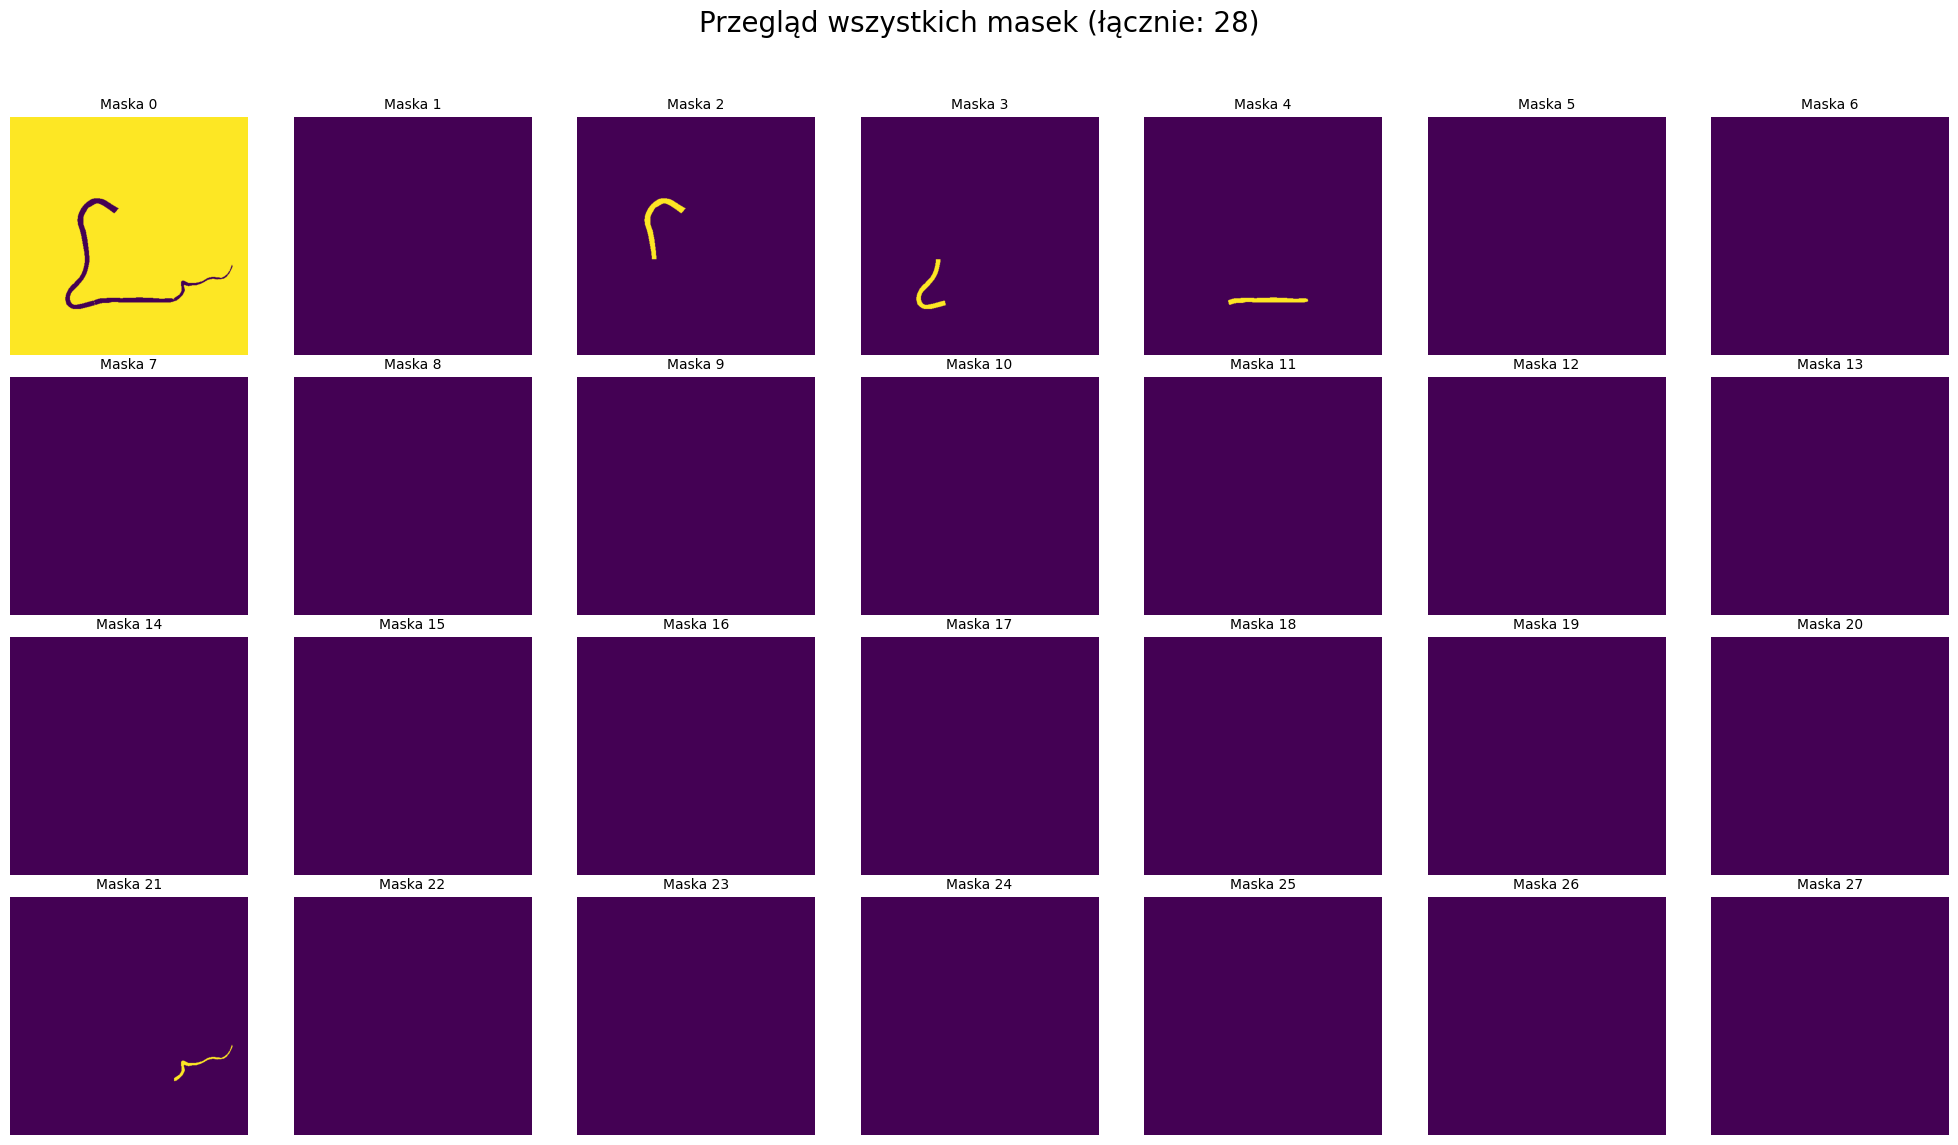

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Zakładamy, że mask ma kształt (512, 512, 28)
num_masks = mask.shape[-1]
cols = 7  # liczba kolumn w siatce
rows = (num_masks // cols) + (1 if num_masks % cols != 0 else 0)

fig, axes = plt.subplots(rows, cols, figsize=(20, 3 * rows))
fig.suptitle(f'Przegląd wszystkich masek (łącznie: {num_masks})', fontsize=20)

axes = axes.flatten()

for i in range(num_masks):
    # Pobieramy i-tą maskę
    single_mask = mask[:, :, i]
    
    # Wyświetlamy
    im = axes[i].imshow(single_mask, cmap='viridis')
    axes[i].set_title(f'Maska {i}', fontsize=10)
    axes[i].axis('off')

# Ukrywamy puste podwykresy, jeśli 28 nie dzieli się idealnie przez liczbę kolumn
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [12]:
import json
import numpy as np
from PIL import Image
from torch_arcade import ARCADESemanticSegmentation
import os
from pycocotools import mask as mask_utils
from zipfile import BadZipFile

output_root_dir = "arcade_coco_dataset_multiclass_seg"
os.makedirs(output_root_dir, exist_ok=True)

for split in ["train", "valid", "test"]:
    split_path = os.path.join(output_root_dir, split)
    os.makedirs(split_path, exist_ok=True)

print(f"Created directory structure under: {output_root_dir}")

# ✅ RZECZYWISTE NAZWY KLAS - Tętnice wieńcowe
CLASS_ID_TO_LABEL = {
    1: "RCA_prox",
    2: "RCA_mid",
    3: "RCA_dist",
    4: "PDA",
    5: "LM",
    6: "LAD_prox",
    7: "LAD_mid",
    8: "LAD_apical",
    9: "D1",
    10: "D1_branch_9a",
    11: "D2",
    12: "D2_branch_10a",
    13: "LCx_prox_11",
    14: "OM1_12",
    15: "OM1_branch_12a",
    16: "LCx_mid_13",
    17: "OM2_14",
    18: "OM2_branch_14a",
    19: "LCx_dist_15",
    20: "PLB_16",
    21: "PLB_branch_16a",
    22: "PLB_branch_16b",
    23: "PLB_branch_16c",
    24: "OM1_branch_12b",
    25: "OM2_branch_14b",
    26: "stenosis",
}

CLASS_ID_TO_FULL_LABEL = {
    1: "1: RCA prox",
    2: "2: RCA mid",
    3: "3: RCA dist",
    4: "4: PDA",
    5: "5: LM",
    6: "6: LAD prox",
    7: "7: LAD mid",
    8: "8: LAD apical",
    9: "9: D1",
    10: "10: D1 branch (9a)",
    11: "11: D2",
    12: "12: D2 branch (10a)",
    13: "13: LCx prox (11)",
    14: "14: OM1 (12)",
    15: "15: OM1 branch (12a)",
    16: "16: LCx mid (13)",
    17: "17: OM2 (14)",
    18: "18: OM2 branch (14a)",
    19: "19: LCx dist (15)",
    20: "20: PLB (16)",
    21: "21: PLB branch (16a)",
    22: "22: PLB branch (16b)",
    23: "23: PLB branch (16c)",
    24: "24: OM1 branch (12b)",
    25: "25: OM2 branch (14b)",
    26: "26: stenosis",
}

categories = [
    {
        "id": class_id,
        "name": CLASS_ID_TO_LABEL[class_id],
        "supercategory": "stenosis" if class_id == 26 else "coronary_artery"
    }
    for class_id in range(1, 27)
]

print(f"✓ Defined {len(categories)} COCO categories for coronary artery segmentation.")

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

def mask_to_rle(mask):
    """Konwertuje binarną maskę do formatu RLE zgodnego z COCO."""
    mask = np.asfortranarray(mask.astype(np.uint8))
    rle = mask_utils.encode(mask)
    rle['counts'] = rle['counts'].decode('utf-8')
    return rle

def mask_to_polygon(mask):
    """Konwertuje binarną maskę na format polygon COCO."""
    import cv2
    mask_uint8 = mask.astype(np.uint8)
    
    # Upewnij się, że maska jest 2D
    if mask_uint8.ndim > 2:
        mask_uint8 = mask_uint8.squeeze()
    
    contours_cv, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for contour in contours_cv:
        if contour.size >= 6:
            contour = contour.flatten().tolist()
            polygons.append(contour)
    return polygons if polygons else [[]]

def convert_mask_to_bbox(mask):
    """Oblicza bounding box z binarnej maski w formacie COCO [x, y, width, height]."""
    y_coords, x_coords = np.where(mask > 0)
    
    if len(x_coords) == 0 or len(y_coords) == 0:
        return [0, 0, 0, 0]
    
    x_min = int(np.min(x_coords))
    y_min = int(np.min(y_coords))
    x_max = int(np.max(x_coords))
    y_max = int(np.max(y_coords))
    
    width = x_max - x_min + 1
    height = y_max - y_min + 1
    
    return [x_min, y_min, width, height]

def convert_multichannel_to_class_mask(mask):
    """
    Konwertuje maskę wielokanałową (H, W, C) na maskę z indeksami klas (H, W).
    Kanał 0 = tło, kanały 1-26 = klasy (stenosis na kanale 26 lub 27).
    """
    if not isinstance(mask, np.ndarray):
        mask = np.array(mask)
    
    # Jeśli maska jest już 2D z indeksami klas, zwróć ją
    if mask.ndim == 2:
        return mask
    
    # Obsługa maski (H, W, C)
    if mask.ndim == 3:
        num_channels = mask.shape[2]
        
        # Sprawdź czy to maska wielokanałowa (one-hot lub prawdopodobieństwa)
        if num_channels > 1:
            # Pomijamy kanał 0 (tło) i bierzemy argmax z pozostałych
            # Kanały 1-26 odpowiadają klasom 1-26
            # Jeśli jest 28 kanałów: 0=tło, 1-26=klasy, 27=stenosis(?)
            
            # Metoda 1: argmax po wszystkich kanałach
            class_mask = np.argmax(mask, axis=2)
            
            # Jeśli argmax daje 0, to tło - sprawdź czy coś jest aktywne
            # Dla kanałów binarnych (0/1), gdzie klasa jest tam gdzie wartość > 0
            if mask.max() <= 1:
                # Maski binarne - znajdź która klasa jest aktywna dla każdego piksela
                class_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)
                for ch in range(1, min(num_channels, 27)):  # Kanały 1-26
                    channel_mask = mask[:, :, ch]
                    if channel_mask.max() > 0:
                        # Binaryzuj kanał
                        binary = (channel_mask > 0.5).astype(np.uint8)
                        class_mask[binary > 0] = ch
            
            return class_mask
        else:
            # Pojedynczy kanał
            return mask[:, :, 0]
    
    return mask

def extract_instances_from_mask(mask, debug=False):
    """
    Wyodrębnia osobne instancje z maski.
    Obsługuje zarówno maski wielokanałowe (H, W, C) jak i z indeksami klas (H, W).
    Zwraca listę (class_id, binary_mask) dla każdej instancji.
    """
    import cv2
    instances = []
    
    # Konwertuj do numpy
    if not isinstance(mask, np.ndarray):
        mask = np.array(mask)
    
    if debug:
        print(f"  Input mask shape: {mask.shape}, dtype: {mask.dtype}")
    
    # === OBSŁUGA MASKI WIELOKANAŁOWEJ (H, W, C) ===
    if mask.ndim == 3 and mask.shape[2] > 1:
        num_channels = mask.shape[2]
        if debug:
            print(f"  Multi-channel mask detected: {num_channels} channels")
        
        # Iteruj po kanałach (1-26 = klasy, 0 = tło)
        for ch in range(1, min(num_channels, 27)):
            channel_mask = mask[:, :, ch]
            
            # Sprawdź czy kanał ma jakiekolwiek dane
            if channel_mask.max() <= 0:
                continue
            
            # Binaryzuj kanał
            if channel_mask.max() <= 1:
                binary_mask = (channel_mask > 0.5).astype(np.uint8)
            else:
                binary_mask = (channel_mask > 0).astype(np.uint8)
            
            if np.sum(binary_mask) < 10:
                continue
            
            # Rozdziel na connected components
            try:
                num_labels, labels = cv2.connectedComponents(binary_mask)
                for instance_id in range(1, num_labels):
                    instance_mask = (labels == instance_id).astype(np.uint8)
                    if np.sum(instance_mask) > 10:
                        instances.append((ch, instance_mask))  # ch = class_id
            except Exception as e:
                if debug:
                    print(f"  Error in connectedComponents for channel {ch}: {e}")
                if np.sum(binary_mask) > 10:
                    instances.append((ch, binary_mask))
        
        return instances
    
    # === OBSŁUGA MASKI 2D Z INDEKSAMI KLAS ===
    if mask.ndim == 3 and mask.shape[2] == 1:
        mask = mask[:, :, 0]
    
    if mask.ndim != 2:
        print(f"  Error: Cannot handle mask with shape {mask.shape}")
        return instances
    
    if debug:
        unique_vals = np.unique(mask)
        print(f"  2D class-index mask: unique values = {unique_vals[:15]}")
    
    # Znajdź wszystkie unikalne klasy (pomijając tło = 0)
    unique_classes = np.unique(mask)
    unique_classes = unique_classes[unique_classes > 0]
    
    for class_id in unique_classes:
        if class_id > 26:
            continue
        
        class_mask = (mask == class_id).astype(np.uint8)
        
        if np.sum(class_mask) < 10:
            continue
        
        # Rozdziel na connected components
        try:
            num_labels, labels = cv2.connectedComponents(class_mask)
            for instance_id in range(1, num_labels):
                instance_mask = (labels == instance_id).astype(np.uint8)
                if np.sum(instance_mask) > 10:
                    instances.append((int(class_id), instance_mask))
        except Exception as e:
            if debug:
                print(f"  Error in connectedComponents for class {class_id}: {e}")
            if np.sum(class_mask) > 10:
                instances.append((int(class_id), class_mask))
    
    return instances

def clean_corrupted_cache(mask_dir, img_id):
    """Usuwa uszkodzony plik cache maski."""
    import glob
    # Szukaj pliku cache dla danego obrazu
    cache_pattern = os.path.join(mask_dir, f"*_{img_id}_*.npz")
    matching_files = glob.glob(cache_pattern)
    
    # Usuń również bezpośredni plik
    direct_file = os.path.join(mask_dir, f"{img_id}.npz")
    if os.path.exists(direct_file):
        matching_files.append(direct_file)
    
    for cache_file in matching_files:
        try:
            os.remove(cache_file)
            print(f"  🗑️  Removed corrupted cache: {cache_file}")
            return True
        except Exception as e:
            print(f"  ⚠️  Failed to remove {cache_file}: {e}")
    
    return False

# ✅ GŁÓWNA PĘTLA KONWERSJI
for split_name in ["train", "valid", "test"]:
    print(f"\n{'='*60}")
    print(f"Processing {split_name.upper()} split...")
    print(f"{'='*60}")
    
    arcade_image_set = split_name if split_name != "valid" else "val"
    
    # Załaduj dataset ARCADE
    try:
        current_dataset = ARCADESemanticSegmentation(
            "dataset/",
            image_set=arcade_image_set,
            download=False
        )
        print("✓ Using ARCADESemanticSegmentation dataset")
    except Exception as e:
        print(f"Failed to load ARCADESemanticSegmentation: {e}")
        print("Trying ARCADEBinarySegmentation...")
        from torch_arcade import ARCADEBinarySegmentation
        current_dataset = ARCADEBinarySegmentation(
            "dataset/",
            image_set=arcade_image_set,
            download=False
        )
        print("✓ Using ARCADEBinarySegmentation dataset")
    
    coco_images = []
    coco_annotations = []
    annotation_id_counter = 0
    image_id_counter = 0
    images_without_objects = 0
    total_instances = 0
    skipped_images = 0
    
    # Statystyki klas
    class_instance_counts = {i: 0 for i in range(1, 27)}
    
    # Iteruj przez dataset z obsługą błędów
    dataset_length = len(current_dataset)
    i = 0
    
    while i < dataset_length:
        try:
            img, mask = current_dataset[i]
            
            # Diagnostyka pierwszego obrazu
            if i == 0:
                mask_np = np.array(mask) if not isinstance(mask, np.ndarray) else mask
                print(f"\n🔍 First sample diagnostics:")
                print(f"   Image type: {type(img)}, size: {img.size if hasattr(img, 'size') else 'N/A'}")
                print(f"   Mask shape: {mask_np.shape}, dtype: {mask_np.dtype}")
                print(f"   Mask min: {mask_np.min()}, max: {mask_np.max()}")
                if mask_np.ndim == 3:
                    print(f"   Mask channels with data: ", end="")
                    active_channels = [ch for ch in range(mask_np.shape[2]) if mask_np[:,:,ch].max() > 0]
                    print(f"{active_channels[:10]}{'...' if len(active_channels) > 10 else ''}")
            
            image_id_counter += 1
            img_width, img_height = img.size
            image_filename = f"{image_id_counter:06d}.jpg"
            image_path = os.path.join(output_root_dir, split_name, image_filename)
            
            # Zapisz obraz
            img.save(image_path)
            
            coco_images.append({
                "id": image_id_counter,
                "width": img_width,
                "height": img_height,
                "file_name": image_filename
            })
            
            # Wyodrębnij wszystkie instancje
            instances = extract_instances_from_mask(mask, debug=(i == 0))
            
            if len(instances) == 0:
                images_without_objects += 1
            
            # Dla każdej instancji, stwórz osobną annotację
            for class_id, instance_mask in instances:
                bbox = convert_mask_to_bbox(instance_mask)
                area = int(np.sum(instance_mask))
                
                if area > 0 and bbox[2] > 0 and bbox[3] > 0:
                    try:
                        segmentation = mask_to_polygon(instance_mask)
                        
                        # Sprawdź czy polygon jest prawidłowy
                        if segmentation and segmentation != [[]] and len(segmentation[0]) >= 6:
                            annotation_id_counter += 1
                            total_instances += 1
                            class_instance_counts[class_id] += 1
                            
                            coco_annotations.append({
                                "id": annotation_id_counter,
                                "image_id": image_id_counter,
                                "category_id": class_id,
                                "segmentation": segmentation,
                                "area": area,
                                "bbox": bbox,
                                "iscrowd": 0
                            })
                    except Exception as e:
                        print(f"⚠️  Warning: Failed to encode mask for image {image_id_counter}, "
                              f"class {class_id}: {e}")
            
            # Progress
            if (i + 1) % 100 == 0:
                print(f"  Processed {i + 1}/{dataset_length} images... ({total_instances} instances, {skipped_images} skipped)")
            
            i += 1
            
        except (BadZipFile, OSError, IOError) as e:
            print(f"\n⚠️  Error loading image {i}: {e}")
            print(f"  Attempting to clean corrupted cache...")
            
            # Spróbuj usunąć uszkodzony cache
            if hasattr(current_dataset, 'mask_dir'):
                try:
                    # Pobierz ID obrazu
                    img_filename = current_dataset.ids[i]
                    img_id = current_dataset.file_to_id.get(img_filename, i)
                    clean_corrupted_cache(current_dataset.mask_dir, img_id)
                except:
                    pass
            
            skipped_images += 1
            i += 1
            continue
            
        except Exception as e:
            print(f"\n❌ Unexpected error at image {i}: {type(e).__name__}: {e}")
            skipped_images += 1
            i += 1
            continue
    
    # Zapisz COCO JSON
    coco_json = {
        "images": coco_images,
        "annotations": coco_annotations,
        "categories": categories
    }
    
    output_annotation_path = os.path.join(output_root_dir, split_name, "_annotations.coco.json")
    
    with open(output_annotation_path, "w") as f:
        json.dump(coco_json, f, indent=4, cls=NpEncoder)
    
    # Statystyki
    print(f"\n{'='*60}")
    print(f"✅ {split_name.upper()} SPLIT COMPLETE")
    print(f"{'='*60}")
    print(f"  📊 Images: {len(coco_images)}")
    print(f"  📊 Annotations: {len(coco_annotations)}")
    print(f"  📊 Total instances: {total_instances}")
    print(f"  📊 Images without objects: {images_without_objects}")
    print(f"  📊 Skipped (corrupted): {skipped_images}")
    print(f"\n  🫀 Class distribution (top 15):")
    
    sorted_classes = sorted(class_instance_counts.items(), key=lambda x: x[1], reverse=True)
    for class_id, count in sorted_classes[:15]:
        if count > 0:
            print(f"     {CLASS_ID_TO_FULL_LABEL[class_id]:30s}: {count:5d} instances")
    
    remaining = sum(count for _, count in sorted_classes[15:])
    if remaining > 0:
        active_classes = len([c for c in sorted_classes[15:] if c[1] > 0])
        print(f"     ... and {remaining} instances in {active_classes} other classes")

print(f"\n{'='*60}")
print("✅ COCO-formatted multi-class CORONARY ARTERY SEGMENTATION dataset complete!")
print(f"{'='*60}")
print(f"📁 Output directory: {output_root_dir}")
print(f"🫀 26 classes: 25 coronary arteries + 1 stenosis")

Created directory structure under: arcade_coco_dataset_multiclass_seg
✓ Defined 26 COCO categories for coronary artery segmentation.

Processing TRAIN split...
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
✓ Using ARCADESemanticSegmentation dataset

🔍 First sample diagnostics:
   Image type: <class 'PIL.PngImagePlugin.PngImageFile'>, size: (512, 512)
   Mask shape: (512, 512, 28), dtype: float64
   Mask min: 0.0, max: 1.0
   Mask channels with data: [0, 2, 3, 4, 21]
  Input mask shape: (512, 512, 28), dtype: float64
  Multi-channel mask detected: 28 channels
  Processed 100/1000 images... (499 instances, 0 skipped)
  Processed 200/1000 images... (998 instances, 0 skipped)
  Processed 300/1000 images... (1505 instances, 0 skipped)
  Processed 400/1000 images... (1995 instances, 0 skipped)
  Processed 500/1000 images... (2522 instances, 0 skipped)
  Processed 600/1000 images... (3004 instances, 0 skipped)
  Processed 700/1000 images... (3506 instances

In [9]:
import json
import numpy as np
from PIL import Image
import supervision as sv
from torch_arcade import ARCADEBinarySegmentation
import os
from pycocotools import mask as mask_utils

output_root_dir = "arcade_coco_dataset_seg"
os.makedirs(output_root_dir, exist_ok=True)

for split in ["train", "valid", "test"]:
    split_path = os.path.join(output_root_dir, split)
    os.makedirs(split_path, exist_ok=True)

print(f"Created directory structure under: {output_root_dir}")

# SEGMENTACJA: Kategorie dla modelu segmentacyjnego
categories = [
    {"id": 1, "name": "segmentation_target", "supercategory": "object"}
]
print("Defined COCO categories for segmentation.")

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

def mask_to_polygon(mask):
    """
    Konwertuje binarną maskę na format polygon COCO (lista współrzędnych).
    """
    # Znajdź kontury w masce
    contours = []
    # Konwersja na uint8
    mask_uint8 = mask.astype(np.uint8)

    # Użyj opencv do znalezienia konturów (opcjonalnie)
    # Jeśli nie masz opencv, użyj pycocotools
    try:
        import cv2
        contours_cv, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        polygons = []
        for contour in contours_cv:
            if contour.size >= 6:  # Co najmniej 3 punkty (x,y pary)
                contour = contour.flatten().tolist()
                polygons.append(contour)
        return polygons if polygons else [[]]
    except ImportError:
        # Fallback: użyj RLE i konwersji z powrotem
        # Dla prostoty, zwróć RLE jako alternatywę
        return mask_to_rle(mask)

def mask_to_rle(mask):
    """Konwertuje binarną maskę do formatu RLE zgodnego z COCO."""
    mask = np.asfortranarray(mask.astype(np.uint8))
    rle = mask_utils.encode(mask)
    rle['counts'] = rle['counts'].decode('utf-8')
    return rle

def convert_mask_to_bbox(mask):
    """Oblicza bounding box z binarnej maski w formacie COCO [x, y, width, height]."""
    y_coords, x_coords = np.where(mask > 0)

    if len(x_coords) == 0 or len(y_coords) == 0:
        return [0, 0, 0, 0]

    x_min = int(np.min(x_coords))
    y_min = int(np.min(y_coords))
    x_max = int(np.max(x_coords))
    y_max = int(np.max(y_coords))

    width = x_max - x_min + 1
    height = y_max - y_min + 1

    return [x_min, y_min, width, height]

for split_name in ["train", "valid", "test"]:
    print(f"\nProcessing {split_name} split...")

    arcade_image_set = split_name if split_name != "valid" else "val"

    current_dataset = ARCADEBinarySegmentation(
        "dataset/",
        image_set=arcade_image_set,
        download=False
    )

    coco_images = []
    coco_annotations = []
    annotation_id_counter = 0
    image_id_counter = 0
    images_without_objects = 0

    for i, (img, mask) in enumerate(current_dataset):
        image_id_counter += 1
        img_width, img_height = img.size
        image_filename = f"{image_id_counter:06d}.jpg"
        image_path = os.path.join(output_root_dir, split_name, image_filename)

        # Zapisz obraz
        img.save(image_path)

        coco_images.append({
            "id": image_id_counter,
            "width": img_width,
            "height": img_height,
            "file_name": image_filename
        })

        # SEGMENTACJA: Używamy polygon zamiast tylko bbox
        if np.any(mask):
            binary_mask = (mask > 0).astype(np.uint8)
            bbox = convert_mask_to_bbox(binary_mask)
            area = int(np.sum(binary_mask))

            if area > 0 and bbox[2] > 0 and bbox[3] > 0:
                try:
                    # Dla segmentacji potrzebujemy polygon lub RLE
                    # RF-DETR akceptuje oba formaty
                    polygons = mask_to_polygon(binary_mask)

                    # Jeśli mask_to_polygon zwraca RLE (gdy opencv niedostępne)
                    if isinstance(polygons, dict):
                        segmentation = polygons
                    else:
                        segmentation = polygons

                    annotation_id_counter += 1

                    coco_annotations.append({
                        "id": annotation_id_counter,
                        "image_id": image_id_counter,
                        "category_id": 1,  # segmentation_target
                        "segmentation": segmentation,
                        "area": area,
                        "bbox": bbox,
                        "iscrowd": 0
                    })
                except Exception as e:
                    print(f"Warning: Failed to encode mask for image {image_id_counter}: {e}")
            else:
                images_without_objects += 1
        else:
            images_without_objects += 1

    coco_json = {
        "images": coco_images,
        "annotations": coco_annotations,
        "categories": categories
    }

    output_annotation_path = os.path.join(output_root_dir, split_name, "_annotations.coco.json")

    with open(output_annotation_path, "w") as f:
        json.dump(coco_json, f, indent=4, cls=NpEncoder)

    print(f"✓ Saved {len(coco_images)} images and {len(coco_annotations)} annotations")
    print(f"  Images without objects: {images_without_objects}")

print("\n✓ COCO-formatted dataset for SEGMENTATION complete.")



Created directory structure under: arcade_coco_dataset_seg
Defined COCO categories for segmentation.

Processing train split...
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
✓ Saved 1000 images and 1000 annotations
  Images without objects: 0

Processing valid split...
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
✓ Saved 200 images and 200 annotations
  Images without objects: 0

Processing test split...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
✓ Saved 300 images and 300 annotations
  Images without objects: 0

✓ COCO-formatted dataset for SEGMENTATION complete.


In [16]:
import rfdetr
print(dir(rfdetr))

['RFDETRBase', 'RFDETRLarge', 'RFDETRMedium', 'RFDETRNano', 'RFDETRSegPreview', 'RFDETRSmall', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'config', 'datasets', 'detr', 'engine', 'main', 'models', 'os', 'util']


In [18]:
import torch
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [5]:
!pip install git+https://github.com/roboflow/rf-detr.git

  Cloning https://github.com/roboflow/rf-detr.git to /tmp/pip-req-build-bvhgfugo
  Running command git clone --filter=blob:none --quiet https://github.com/roboflow/rf-detr.git /tmp/pip-req-build-bvhgfugo
  Resolved https://github.com/roboflow/rf-detr.git to commit 35ac6ab64634e188bbb0fa3fc5135132f0df45fc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# 🔍 DIAGNOSTYKA GPU/CPU
import torch

print("=" * 60)
print("🖥️  DEVICE DIAGNOSTICS")
print("=" * 60)

# Sprawdź dostępność CUDA
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

if cuda_available:
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
else:
    print("⚠️  CUDA not available - training will run on CPU (very slow!)")
    print("\n📝 Solutions:")
    print("   • Google Colab: Runtime → Change runtime type → T4 GPU")
    print("   • Local: Install CUDA toolkit + PyTorch with CUDA support")
    print("   • Local Mac: Use MPS backend (Apple Silicon)")

# Sprawdź MPS (Apple Silicon)
if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    print(f"\n🍎 MPS (Apple Silicon) available: True")
    print("   Note: RF-DETR may not fully support MPS yet")
else:
    print(f"\nMPS (Apple Silicon) available: False")

# Rekomendowany device
if cuda_available:
    recommended_device = "cuda"
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    recommended_device = "mps"
else:
    recommended_device = "cpu"

print(f"\n✅ Recommended device: {recommended_device}")
print(f"PyTorch version: {torch.__version__}")
print("=" * 60)

In [ ]:
# 🔍 WIZUALIZACJA Z MASKAMI - 28 KLAS Z RÓŻNYMI KOLORAMI
from rfdetr import RFDETRSegLarge
import supervision as sv
from PIL import Image
import numpy as np

# Wybierz próbkę
sample_idx = 4
path, _, annotations = ds[sample_idx]
image = Image.open(path).convert('RGB')

detections = model.predict(image, threshold=0.5)

# 🔍 DIAGNOSTYKA
print(f"✓ Annotations has mask: {annotations.mask is not None}")
print(f"✓ Detections has mask: {detections.mask is not None}")
print(f"✓ GT class_ids: {annotations.class_id}")
print(f"✓ Pred class_ids: {detections.class_id}")
print(f"✓ Dataset classes ({len(ds.classes)}): {ds.classes}")

# Parametry wizualizacji
text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

# ✅ PALETA 28 KOLORÓW - różne odcienie dla każdej klasy
COLOR_PALETTE_28 = sv.ColorPalette.from_hex([
    "#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF", "#FF8000",  # 1-7
    "#8000FF", "#00FF80", "#FF0080", "#80FF00", "#0080FF", "#FF8080", "#80FF80",  # 8-14
    "#8080FF", "#FFFF80", "#FF80FF", "#80FFFF", "#C00000", "#00C000", "#0000C0",  # 15-21
    "#C0C000", "#C000C0", "#00C0C0", "#FFA500", "#A500FF", "#00FFA5", "#A5FF00"   # 22-28
])

# ✅ Annotatory z paletą kolorów
mask_annotator = sv.MaskAnnotator(color=COLOR_PALETTE_28, opacity=0.5)
label_annotator = sv.LabelAnnotator(
    color=COLOR_PALETTE_28,
    text_color=sv.Color.BLACK,
    text_scale=text_scale
)

# ✅ ETYKIETY Z NAZWAMI KLAS
# Ground truth labels (bez confidence)
gt_labels = [
    ds.classes[class_id] if class_id < len(ds.classes) else f"class_{class_id}"
    for class_id in annotations.class_id
]

# Prediction labels (z confidence) - użyj nazw z datasetu
pred_labels = [
    f"{ds.classes[class_id] if class_id < len(ds.classes) else f'class_{class_id}'} {conf:.2f}"
    for class_id, conf in zip(detections.class_id, detections.confidence)
]

# 🎨 WIZUALIZACJA GROUND TRUTH
annotation_image = image.copy()
if annotations.mask is not None:
    annotation_image = mask_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, gt_labels)

# 🎨 WIZUALIZACJA PREDIKCJI
detections_image = image.copy()
if detections.mask is not None:
    detections_image = mask_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, pred_labels)

sv.plot_images_grid(
    images=[annotation_image, detections_image],
    grid_size=(1, 2),
    titles=["Ground Truth", "Prediction"]
)

In [ ]:
# 🔧 KROK 1: Sprawdź sterowniki i CUDA toolkit
print("=" * 70)
print("🔍 NVIDIA DRIVER & CUDA TOOLKIT CHECK")
print("=" * 70)

import subprocess
import os

# 1. nvidia-smi
print("\n1️⃣  NVIDIA-SMI (GPU driver info):")
try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True, timeout=5)
    if result.returncode == 0:
        print(result.stdout)
    else:
        print(f"❌ nvidia-smi failed: {result.stderr}")
except Exception as e:
    print(f"❌ nvidia-smi error: {e}")

# 2. nvcc --version
print("\n2️⃣  NVCC (CUDA compiler version):")
try:
    result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True, timeout=5)
    if result.returncode == 0:
        print(result.stdout)
    else:
        print(f"❌ nvcc not found: {result.stderr}")
except Exception as e:
    print(f"❌ nvcc error: {e}")

# 3. /dev/nvidia*
print("\n3️⃣  NVIDIA DEVICE FILES:")
try:
    result = subprocess.run(['ls', '-la', '/dev/nvidia*'], capture_output=True, text=True, timeout=5, shell=False)
    nvidia_files = subprocess.run('ls -la /dev/nvidia* 2>/dev/null || echo "No nvidia devices found"', 
                                 shell=True, capture_output=True, text=True)
    print(nvidia_files.stdout)
except Exception as e:
    print(f"❌ Error checking /dev/nvidia*: {e}")

# 4. libcudart.so check
print("\n4️⃣  CUDA RUNTIME LIBRARY:")
cuda_lib_path = "/usr/local/cuda/lib64/libcudart.so"
if os.path.exists(cuda_lib_path):
    print(f"✅ Found: {cuda_lib_path}")
    result = subprocess.run(['ls', '-lh', cuda_lib_path], capture_output=True, text=True)
    print(result.stdout)
else:
    print(f"❌ Not found: {cuda_lib_path}")

print("=" * 70)

In [ ]:
# 🔧 KROK 2: NAPRAW CUDA - ustaw zmienne środowiskowe i przeładuj PyTorch
import os
import sys

print("=" * 70)
print("🛠️  FIXING CUDA ENVIRONMENT")
print("=" * 70)

# Ustaw zmienne środowiskowe dla CUDA
os.environ['CUDA_HOME'] = '/usr/local/cuda'
os.environ['CUDA_PATH'] = '/usr/local/cuda'

# Dodaj CUDA do LD_LIBRARY_PATH
cuda_lib_path = '/usr/local/cuda/lib64'
current_ld_path = os.environ.get('LD_LIBRARY_PATH', '')

if cuda_lib_path not in current_ld_path:
    os.environ['LD_LIBRARY_PATH'] = f"{cuda_lib_path}:{current_ld_path}" if current_ld_path else cuda_lib_path
    print(f"✅ Set LD_LIBRARY_PATH={os.environ['LD_LIBRARY_PATH']}")
else:
    print(f"ℹ️  LD_LIBRARY_PATH already contains CUDA path")

# Dodaj CUDA do PATH
cuda_bin_path = '/usr/local/cuda/bin'
current_path = os.environ.get('PATH', '')

if cuda_bin_path not in current_path:
    os.environ['PATH'] = f"{cuda_bin_path}:{current_path}"
    print(f"✅ Added CUDA to PATH")

print(f"\n📋 Environment variables:")
print(f"   CUDA_HOME: {os.environ.get('CUDA_HOME')}")
print(f"   CUDA_PATH: {os.environ.get('CUDA_PATH')}")
print(f"   LD_LIBRARY_PATH: {os.environ.get('LD_LIBRARY_PATH')}")

# ⚠️ KRYTYCZNE: Usuń torch z pamięci i przeładuj
print("\n🔄 Reloading PyTorch with new environment...")

# Usuń wszystkie moduły torch z sys.modules
torch_modules = [name for name in sys.modules.keys() if 'torch' in name]
for module_name in torch_modules:
    del sys.modules[module_name]
    
print(f"   Removed {len(torch_modules)} torch modules from cache")

# Przeładuj torch
import torch

print("\n" + "=" * 70)
print("🎯 CUDA STATUS AFTER FIX")
print("=" * 70)

cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

if cuda_available:
    print(f"✅ SUCCESS! CUDA is now working!")
    print(f"   Device count: {torch.cuda.device_count()}")
    print(f"   Device name: {torch.cuda.get_device_name(0)}")
    print(f"   CUDA version: {torch.version.cuda}")
else:
    print(f"❌ CUDA still not available")
    print(f"\n🔴 Next steps:")
    print(f"   1. Restart Jupyter kernel (Kernel → Restart Kernel)")
    print(f"   2. Run this cell again")
    print(f"   3. If still fails, check nvidia-smi output above")

print("=" * 70)

## 🔧 Rozwiązanie problemu CUDA

### Diagnoza:
- PyTorch zainstalowany z CUDA 12.8 ✅
- CUDA toolkit zainstalowany w `/usr/local/cuda` ✅
- **Problem**: Zmienne środowiskowe nie są ustawione ❌

### Rozwiązanie:

**Opcja 1: Fix w notebooku (tymczasowy)**
1. Uruchom komórkę "KROK 1" - sprawdzi nvidia-smi i nvcc
2. Uruchom komórkę "KROK 2" - ustawi zmienne środowiskowe i przeładuje PyTorch
3. Jeśli nadal nie działa, **zrestartuj kernel** (Kernel → Restart) i ponownie uruchom komórkę "KROK 2"

**Opcja 2: Permanent fix (trwały)**

Dodaj do `~/.bashrc` lub `~/.zshrc`:
```bash
export CUDA_HOME=/usr/local/cuda
export CUDA_PATH=/usr/local/cuda
export LD_LIBRARY_PATH=/usr/local/cuda/lib64:$LD_LIBRARY_PATH
export PATH=/usr/local/cuda/bin:$PATH
```

Następnie:
```bash
source ~/.bashrc  # lub source ~/.zshrc
```

I **zrestartuj Jupyter kernel**.

### Weryfikacja:
Po naprawie, uruchom ponownie podstawową diagnostykę GPU (wcześniejsza komórka) - powinna pokazać `CUDA available: True`.

In [ ]:
# 🔴 REINSTALACJA PYTORCH Z CUDA 12.x
# Uruchom tę komórkę aby zainstalować PyTorch z obsługą GPU!

import subprocess
import sys

print("=" * 70)
print("🔄 REINSTALLING PYTORCH WITH CUDA SUPPORT")
print("=" * 70)

# Odinstaluj obecny PyTorch
print("\n1️⃣  Removing current PyTorch...")
subprocess.run([sys.executable, "-m", "pip", "uninstall", "-y", "torch", "torchvision", "torchaudio"], 
               capture_output=True)

# Zainstaluj PyTorch z CUDA 12.4 (kompatybilne z CUDA 12.9)
print("\n2️⃣  Installing PyTorch with CUDA 12.4...")
print("    (This may take a few minutes...)\n")

result = subprocess.run([
    sys.executable, "-m", "pip", "install", 
    "torch", "torchvision", "torchaudio",
    "--index-url", "https://download.pytorch.org/whl/cu124"
], capture_output=True, text=True)

if result.returncode == 0:
    print("✅ PyTorch installed successfully!")
else:
    print(f"❌ Installation failed:\n{result.stderr}")

print("\n" + "=" * 70)
print("⚠️  IMPORTANT: RESTART JUPYTER KERNEL NOW!")
print("=" * 70)
print("\n   Kernel → Restart Kernel (or Ctrl+Shift+.)")
print("\n   After restart, run the GPU diagnostic cell again.")
print("=" * 70)

In [ ]:
# 🛠️ KOMPLETNA NAPRAWA CUDA - KROK PO KROKU
# Uruchom tę komórkę i postępuj zgodnie z instrukcjami

import subprocess
import sys
import os

print("=" * 70)
print("🔧 CUDA FIX - FULL DIAGNOSTIC & REPAIR")
print("=" * 70)

# KROK 1: Sprawdź co jest w /usr/local/cuda
print("\n📁 KROK 1: Sprawdzam /usr/local/cuda...")
cuda_version_file = "/usr/local/cuda/version.txt"
cuda_json = "/usr/local/cuda/version.json"

if os.path.exists("/usr/local/cuda"):
    # Sprawdź rzeczywistą wersję CUDA toolkit
    result = subprocess.run("cat /usr/local/cuda/version* 2>/dev/null || ls -la /usr/local/cuda/", 
                           shell=True, capture_output=True, text=True)
    print(f"   {result.stdout[:500]}")
    
    # Sprawdź nvcc
    nvcc_result = subprocess.run("/usr/local/cuda/bin/nvcc --version", 
                                 shell=True, capture_output=True, text=True)
    if nvcc_result.returncode == 0:
        print(f"\n   NVCC version:\n   {nvcc_result.stdout}")
    else:
        print(f"   ⚠️ nvcc not working: {nvcc_result.stderr}")

# KROK 2: Sprawdź czy PyTorch naprawdę ma CUDA
print("\n🔍 KROK 2: Sprawdzam PyTorch binary...")
result = subprocess.run(
    f"{sys.executable} -c \"import torch; print('CUDA:', torch.cuda.is_available()); print('Built:', torch.version.cuda)\"",
    shell=True, capture_output=True, text=True
)
print(f"   {result.stdout}")
if result.stderr:
    print(f"   Errors: {result.stderr[:300]}")

# KROK 3: Sprawdź linkowanie do bibliotek CUDA
print("\n🔗 KROK 3: Sprawdzam linkowanie PyTorch do CUDA...")
torch_path = subprocess.run(
    f"{sys.executable} -c \"import torch; print(torch.__file__)\"",
    shell=True, capture_output=True, text=True
).stdout.strip()

if torch_path:
    torch_dir = os.path.dirname(torch_path)
    lib_dir = os.path.join(torch_dir, "lib")
    
    # Sprawdź czy są biblioteki CUDA w PyTorch
    result = subprocess.run(f"ls {lib_dir}/*cuda* 2>/dev/null | head -5", 
                           shell=True, capture_output=True, text=True)
    if result.stdout:
        print(f"   ✅ CUDA libs in PyTorch:\n   {result.stdout}")
    else:
        print(f"   ❌ NO CUDA libraries in PyTorch package!")
        print(f"   ⚠️  PyTorch jest zainstalowany jako CPU-only!")

print("\n" + "=" * 70)
print("📋 ROZWIĄZANIE:")
print("=" * 70)
print("""
Twój PyTorch prawdopodobnie jest wersją CPU-only mimo nazwy 'cu128'.

🔴 WYKONAJ W TERMINALU (nie w notebooku):

# 1. Aktywuj środowisko wirtualne
source /home/ives/rafal/rf-detr-seg/notebooks/notebooks/venv/bin/activate

# 2. Usuń obecny PyTorch
pip uninstall -y torch torchvision torchaudio

# 3. Wyczyść cache pip
pip cache purge

# 4. Zainstaluj PyTorch z CUDA 12.4 (kompatybilne z 12.9)
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

# 5. Zrestartuj Jupyter kernel

# 6. Sprawdź
python -c "import torch; print(torch.cuda.is_available())"
""")
print("=" * 70)

In [13]:
# ===== TRENING MODELU SEGMENTACYJNEGO =====
from rfdetr import RFDETRSegNano  # Możesz też użyć RFDETRSegSmall, RFDETRSegMedium, etc.

# Inicjalizacja modelu segmentacyjnego
model = RFDETRSegNano(load_pretrain=False, pretrained_weights=None)

# Trening
model.train(
    dataset_dir="/Users/rafalszulinski/Desktop/developing/IVES/coronary/rf-detr-seg/notebooks/notebooks/arcade_coco_dataset_multiclass_seg",
    epochs=1,
    batch_size=4,
    grad_accum_steps=4,
    lr=1e-4,
    output_dir="output_segmentation"
)

print("\n✓ Training complete!")

ModuleNotFoundError: No module named 'rfdetr'

In [11]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

from rfdetr import RFDETRSegLarge

# ✅ ZAŁADUJ PRETRAINED MODEL
model = RFDETRSegLarge(
    load_pretrain=True,  # ✅ Załaduj wagi pretrained
    pretrained_weights="rf-detr-seg-large.pt"  # Domyślna wartość
)

model.train(
    dataset_dir="./arcade_coco_dataset_seg",
    epochs=8,
    batch_size=1,
    grad_accum_steps=16,
    lr=1e-4,
    output_dir="output_segmentation"
)

print("\n✅ Training complete!")

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 12 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


Reinitializing your detection head with 2 classes.


Unable to initialize TensorBoard. Logging is turned off for this session.  Run 'pip install tensorboard' to enable logging.
Not using distributed mode
git:
  sha: 3cae605ff77c80489f9da576abf96199868dfc3b, status: clean, branch: main

Namespace(num_classes=2, grad_accum_steps=16, print_freq=10, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=1, weight_decay=0.0001, epochs=8, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-seg-large.pt', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[3, 6, 9, 12], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=5, dim_feedf

Epoch: [0]  [ 0/62]  eta: 0:02:17  lr: 0.000100  class_error: 0.00  loss: 72.2895 (72.2895)  loss_ce: 5.7371 (5.7371)  loss_bbox: 1.1214 (1.1214)  loss_giou: 0.5487 (0.5487)  loss_mask_ce: 1.1757 (1.1757)  loss_mask_dice: 2.7870 (2.7870)  loss_ce_0: 5.5929 (5.5929)  loss_bbox_0: 1.1032 (1.1032)  loss_giou_0: 0.5959 (0.5959)  loss_mask_ce_0: 1.4471 (1.4471)  loss_mask_dice_0: 3.4108 (3.4108)  loss_ce_1: 5.8524 (5.8524)  loss_bbox_1: 0.9363 (0.9363)  loss_giou_1: 0.5054 (0.5054)  loss_mask_ce_1: 1.6941 (1.6941)  loss_mask_dice_1: 3.4541 (3.4541)  loss_ce_2: 5.7650 (5.7650)  loss_bbox_2: 0.8544 (0.8544)  loss_giou_2: 0.5014 (0.5014)  loss_mask_ce_2: 1.3691 (1.3691)  loss_mask_dice_2: 2.9187 (2.9187)  loss_ce_3: 5.7636 (5.7636)  loss_bbox_3: 0.9807 (0.9807)  loss_giou_3: 0.4963 (0.4963)  loss_mask_ce_3: 1.2290 (1.2290)  loss_mask_dice_3: 2.9170 (2.9170)  loss_ce_enc: 5.6787 (5.6787)  loss_bbox_enc: 1.1032 (1.1032)  loss_giou_enc: 0.5817 (0.5817)  loss_mask_ce_enc: 2.0594 (2.0594)  loss_mas

## Run Inference with Fine-tuned RF-DETR Model

In [5]:
from rfdetr import RFDETRBase
import supervision as sv
from PIL import Image

path, image, annotations = ds[0]
image = Image.open(path).convert('RGB')

detections = model.predict(image, threshold=0.5)

text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)
color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
    "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

bbox_annotator = sv.BoxAnnotator(color=color,thickness=thickness)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale)

annotations_labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

detections_labels = [
    f"{ds.classes[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])

IndexError: list index out of range

✓ Model classes: {1: 'segmentation_target'}
✓ Dataset classes: ['segmentation_target']


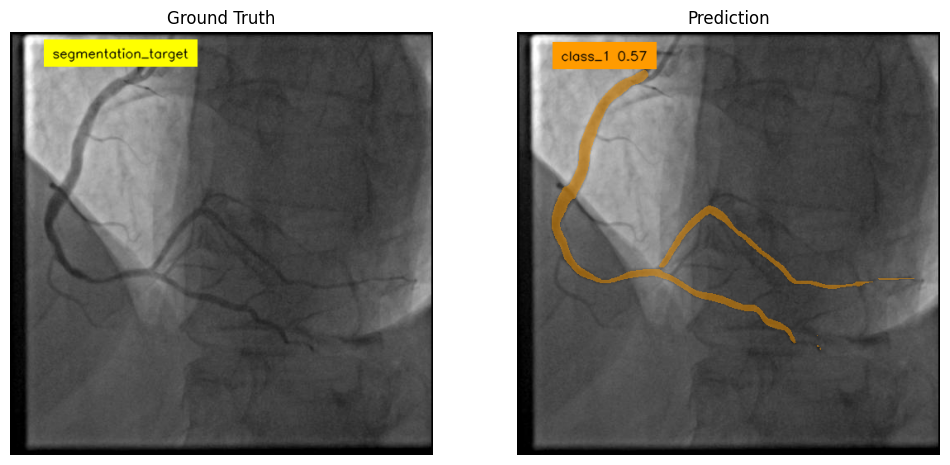

In [27]:
from rfdetr import RFDETRSegLarge
import supervision as sv
from PIL import Image

path, image, annotations = ds[50]
image = Image.open(path).convert('RGB')

detections = model.predict(image, threshold=0.5)

# 🔥 POBIERZ NAZWY KLAS Z MODELU (nie z datasetu)
model_classes = model.class_names  # To zwraca dict: {1: 'class_name', ...}

print(f"✓ Model classes: {model_classes}")
print(f"✓ Dataset classes: {ds.classes}")

# Parametry wizualizacji
text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)
color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080"
])

# Annotatory dla segmentacji
mask_annotator = sv.MaskAnnotator(color=color, opacity=0.5)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale
)

# ✅ UŻYJ NAZW KLAS Z MODELU
annotations_labels = [
    model_classes.get(class_id + 1, ds.classes[class_id] if class_id < len(ds.classes) else f"class_{class_id}")
    for class_id in annotations.class_id
]

detections_labels = [
    f"{model_classes.get(class_id + 1, f'class_{class_id}')} {confidence:.2f}"
    for class_id, confidence in zip(detections.class_id, detections.confidence)
]

# Wizualizacja
annotation_image = image.copy()
annotation_image = mask_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = mask_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

sv.plot_images_grid(
    images=[annotation_image, detections_image],
    grid_size=(1, 2),
    titles=["Ground Truth", "Prediction"]
)

In [ ]:
# from inference import get_model

# MODEL_ID = "basketball-player-detection-2/13"
# model_rf = get_model(model_id=MODEL_ID, api_key = userdata.get("ROBOFLOW_API_KEY"))

In [ ]:
# import supervision as sv
# from PIL import Image

# path, image, annotations = ds[0]
# image = Image.open(path)

# result = model_rf.infer(image, confidence=0.3)[0]
# detections = sv.Detections.from_inference(result)

# text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
# thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)
# color = sv.ColorPalette.from_hex([
#     "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
#     "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
# ])

# bbox_annotator = sv.BoxAnnotator(color=color,thickness=thickness)
# label_annotator = sv.LabelAnnotator(
#     color=color,
#     text_color=sv.Color.BLACK,
#     text_scale=text_scale)

# annotations_labels = [
#     f"{ds.classes[class_id]}"
#     for class_id
#     in annotations.class_id
# ]

# annotation_image = image.copy()
# annotation_image = bbox_annotator.annotate(annotation_image, annotations)
# annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

# detections_image = image.copy()
# detections_image = bbox_annotator.annotate(detections_image, detections)
# detections_image = label_annotator.annotate(detections_image, detections)

# sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])

<div align="center">
  <p>
    Looking for more tutorials or have questions?
    Check out our <a href="https://github.com/roboflow/notebooks">GitHub repo</a> for more notebooks,
    or visit our <a href="https://discord.gg/GbfgXGJ8Bk">discord</a>.
  </p>
  
  <p>
    <strong>If you found this helpful, please consider giving us a ⭐
    <a href="https://github.com/roboflow/notebooks">on GitHub</a>!</strong>
  </p>

</div>